In [1]:
# Zachary Katz
# zachary_katz@mines.edu
# 02 August 2024

# Plot Figure 3 for Whillans Catalog Paper
# Events on top of tides

# Imports
import datetime

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import scipy

import pyTMD.io
import pyTMD.time
import timescale
from astropy.timeseries import LombScargle
import matplotlib as mpl
import matplotlib.dates as mdates

In [2]:
# Load slip times based on second derivative
ev_data = {"event": [], "trace_time": []}
df = pd.read_csv("AllEventStartTimes_2stas.txt", sep="\t")
ev_data["ev_time"] = df["EventStartTime"]

In [3]:
# Try no data from txt file
no_data = {"interval": [], "starts": [], "ends": []}
df = pd.read_csv("no_data_2stas.txt", sep="\t")
no_data["starts"] = df["start"]
no_data["ends"] = df["end"]
diff = [
    datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
    - datetime.datetime.strptime(y, "%Y-%m-%d %H:%M:%S")
    for x, y in zip(no_data["ends"], no_data["starts"])
]
no_data["interval"] = diff

In [4]:
print(no_data["starts"][0])

2008-01-01 00:00:00


In [4]:
# Calculate time since last events
time_since_last_ev = [
    datetime.timedelta(seconds=1000000)
]  # Set large for first event because prior event time unknown
for i, event in enumerate(ev_data["ev_time"]):
    if i > 0:
        diff = datetime.datetime.strptime(
            ev_data["ev_time"][i], "%Y-%m-%d %H:%M:%S"
        ) - datetime.datetime.strptime(ev_data["ev_time"][i - 1], "%Y-%m-%d %H:%M:%S")
        time_since_last_ev.append(diff)
ev_data["time_since_last_ev"] = time_since_last_ev
print([(a.days * 24 * 3600 + a.seconds) / 3600 for a in ev_data["time_since_last_ev"]])

[277.77777777777777, 17.354166666666668, 21.766666666666666, 10.758333333333333, 13.254166666666666, 19.1125, 22.970833333333335, 10.4875, 11.895833333333334, 9.975, 14.345833333333333, 9.975, 14.845833333333333, 9.9875, 14.658333333333333, 12.0625, 13.1375, 9.808333333333334, 15.225, 10.9875, 14.591666666666667, 10.625, 15.1, 23.866666666666667, 8.416666666666666, 16.3375, 21.929166666666667, 10.666666666666666, 14.5875, 18.954166666666666, 14.941666666666666, 10.7375, 20.645833333333332, 13.025, 12.041666666666666, 11.0125, 13.125, 9.525, 15.145833333333334, 8.875, 15.625, 8.2875, 16.266666666666666, 8.525, 16.9125, 8.5125, 16.4875, 8.55, 19.804166666666667, 16.733333333333334, 11.6625, 12.2, 12.983333333333333, 13.9, 21.4, 20.2, 12.008333333333333, 11.979166666666666, 11.516666666666667, 12.891666666666667, 11.183333333333334, 13.1125, 11.1, 13.5125, 11.545833333333333, 13.420833333333333, 10.85, 14.083333333333334, 10.420833333333333, 14.325, 11.045833333333333, 16.941666666666666,

In [6]:
def tides_mm(dates, lat, lon):
    """
    Calcs tides at times for 1 location lat,lon
    times must be in datetime format
    lat, lon floats

    Returns tides in cm
    """
    years = np.array([date.year for date in dates])
    months = np.array([date.month for date in dates])
    days = np.array([date.day for date in dates])
    hours = np.array([date.hour for date in dates])
    minutes = np.array([date.minute for date in dates])

    dir = "/mnt/c/Users/ZacharyKatz/Desktop/Research/Background"
    mod = "CATS2008-v2023"
    model = pyTMD.io.model(dir, format="netcdf").elevation(mod)

    # Calcluate date since Jan 1, 1992 [The format pyTMD wants it in]
    tide_time = timescale.time.convert_calendar_dates(
        year=years, month=months, day=days, hour=hours, minute=minutes
    )
    print(model.format)
    constituents = pyTMD.io.OTIS.read_constants(
        model.grid_file,
        model.model_file,
        model.projection,
        type=model.type,
        grid=model.format,
    )
    constituents.pop("mf")
    constituents.pop("m2")
    constituents.pop("s2")
    constituents.pop("n2")
    constituents.pop("k2")
    constituents.pop("o1")
    constituents.pop("p1")
    constituents.pop("q1")
    constituents.pop("k1")
    print(constituents)
    c = constituents.fields

    DELTAT = np.zeros_like(tide_time)
    amp, ph, D = pyTMD.io.OTIS.interpolate_constants(
        np.atleast_1d(lon),
        np.atleast_1d(lat),
        constituents,
        model.projection,
        type=model.type,
        method="spline",
        extrapolate=True,
    )

    # calculate complex phase in radians for Euler's
    cph = -1j * ph * np.pi / 180.0
    # calculate constituent oscillation
    hc = amp * np.exp(cph)
    # predict tidal elevations at time 1 and infer minor corrections
    TIDE = pyTMD.predict.time_series(
        tide_time, hc, c, deltat=DELTAT, corrections=model.format
    )
    # MINOR = pyTMD.predict.infer_minor(tide_time, hc, c,
    #    deltat=DELTAT, corrections=model.format)
    # TIDE.data[:] += MINOR.data[:]
    # convert to centimeters
    TIDE.data[:] *= 100.0

    return TIDE.data

In [5]:
def tides(dates, lat, lon):
    """
    Calcs tides at times for 1 location lat,lon
    times must be in datetime format
    lat, lon floats

    Returns tides in cm
    """
    years = np.array([date.year for date in dates])
    months = np.array([date.month for date in dates])
    days = np.array([date.day for date in dates])
    hours = np.array([date.hour for date in dates])
    minutes = np.array([date.minute for date in dates])

    dir = "/mnt/c/Users/ZacharyKatz/Desktop/Research/Background"
    mod = "CATS2008-v2023"
    model = pyTMD.io.model(dir, format="netcdf").elevation(mod)

    # Calcluate date since Jan 1, 1992 [The format pyTMD wants it in]
    tide_time = timescale.time.convert_calendar_dates(
        year=years, month=months, day=days, hour=hours, minute=minutes
    )
    print(model.format)
    constituents = pyTMD.io.OTIS.read_constants(
        model.grid_file,
        model.model_file,
        model.projection,
        type=model.type,
        grid=model.format,
    )
    print(constituents)
    c = constituents.fields

    DELTAT = np.zeros_like(tide_time)
    amp, ph, D = pyTMD.io.OTIS.interpolate_constants(
        np.atleast_1d(lon),
        np.atleast_1d(lat),
        constituents,
        model.projection,
        type=model.type,
        method="spline",
        extrapolate=True,
    )

    # calculate complex phase in radians for Euler's
    cph = -1j * ph * np.pi / 180.0
    # calculate constituent oscillation
    hc = amp * np.exp(cph)
    # predict tidal elevations at time 1 and infer minor corrections
    TIDE = pyTMD.predict.time_series(
        tide_time, hc, c, deltat=DELTAT, corrections=model.format
    )
    MINOR = pyTMD.predict.infer_minor(
        tide_time, hc, c, deltat=DELTAT, corrections=model.format
    )
    TIDE.data[:] += MINOR.data[:]
    # convert to centimeters
    TIDE.data[:] *= 100.0

    return TIDE.data

[(-174.11568595746584, -84.38504722396503), (-174.07363790894706, -84.38708087490528), (-174.03252834334145, -84.38929637003153), (-173.9941263318061, -84.39193572017322), (-173.95194821792526, -84.39181611372216), (-173.90710899077706, -84.39045168887456), (-173.86118811502547, -84.38949590176401), (-173.8148291962652, -84.38878233553352), (-173.76803047357416, -84.38841239171828), (-173.72112609045024, -84.38834365932638), (-173.6742274584149, -84.38855870689241), (-173.62764576571297, -84.38910967700275), (-173.5814536310214, -84.38993610577346), (-173.53591166420026, -84.3910466307691), (-173.49112552234823, -84.39243260584267), (-173.44773757602218, -84.39419044387766), (-173.40529722592322, -84.39616056496061), (-173.36429498918946, -84.39840763385244), (-173.32440343132876, -84.40084127031444), (-173.28402159579116, -84.40319834133297), (-173.24328319333878, -84.40550028801066), (-173.20251122152564, -84.4077994127134), (-173.16170568018524, -84.41009571193077), (-173.1203332639

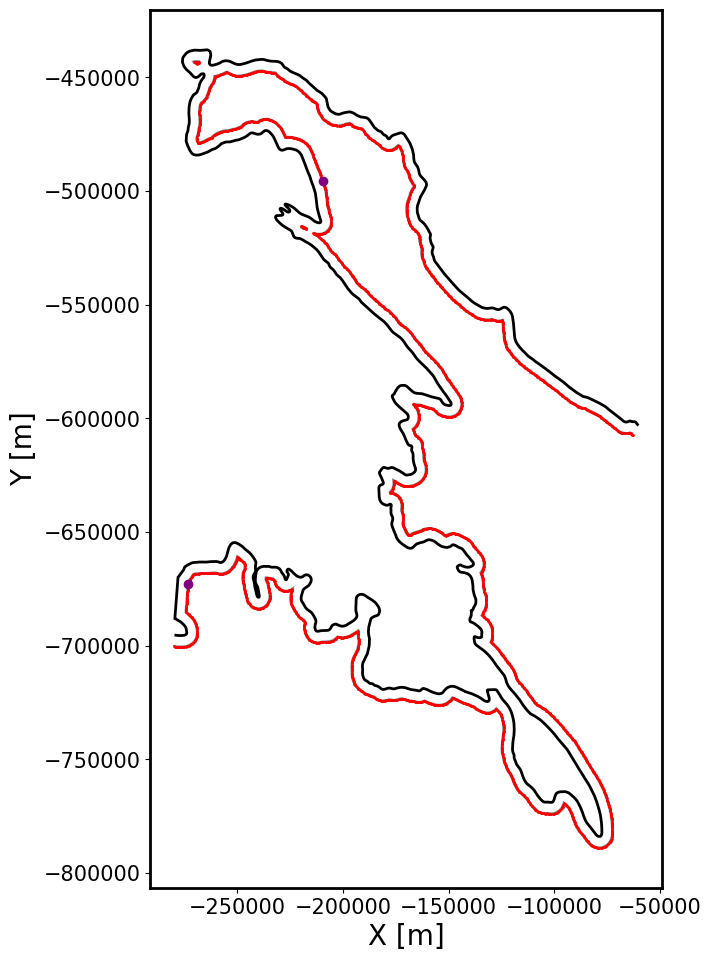

In [26]:
# Calculate difference in tides across basin at event times (from icesat2/gztides.ipynb)
# Helper functions
import datetime

import matplotlib.ticker as ticker


import pandas as pd


import pyTMD.io
import pyTMD.time


from pyproj import CRS, Transformer
import shapefile
import shapely
from shapely.plotting import plot_line
from shapely.geometry import LineString


def inBox(points, bbox):
    # Return points from points that are in bbox
    inbox = []
    for point in points:
        x = point[0]
        y = point[1]
        if x > bbox[0] and x < bbox[2] and y > bbox[1] and y < bbox[3]:
            inbox.append(point)
    return inbox


def interpolateLine(line, dist):
    # Return a new list of points from a linestring that has been interpolated at
    # distance dist. Line must be linestring, dist in m for our case

    # Follows example from:
    # https://stackoverflow.com/questions/34906124/interpolating-every-x-distance-along-multiline-in-shapely
    length = shapely.length(line)
    num_vert = int(np.round(length / dist))
    # print(num_vert)
    return [line.interpolate(n * dist) for n in range(num_vert)]


def xy2ll(x, y):
    """
     Transform coordinates to geodetic coordinates (lon, lat)
     from Antarctic Polar Stereograph coordinates (x, y)

    lon,lat = xy2ll(x,y)
    """
    crs_ll = CRS("EPSG:4326")
    crs_xy = CRS("EPSG:3031")
    xy_to_ll = Transformer.from_crs(crs_xy, crs_ll, always_xy=True)
    lon, lat = xy_to_ll.transform(x, y)
    return lon, lat


def ll2xy(lon, lat):
    """
    Transform coordinates from input geodetic coordinates (lon, lat)
    to output Antarctic Polar Stereographic coordinates (x, y)
    Can also take lists of floats!

    Parameters
    lon - Geodetic longitude in EPSG:4326 [float]
    lat - Geodetic latitude in EPSG:4326 [float]

    Returns
    x - Antarctic Polar Stereographic (EPSG:3031) x [float]
    y - Antarctic Polar Stereographic (EPSG:3031) y [float]
    """

    crs_ll = CRS("EPSG:4326")
    crs_xy = CRS("EPSG:3031")
    ll_to_xy = Transformer.from_crs(crs_ll, crs_xy, always_xy=True)
    x, y = ll_to_xy.transform(lon, lat)
    return x, y


def dist_sq(x, y):
    # Returns min dist squared between two points
    delta_x = y[0] - x[0]
    delta_y = y[1] - x[1]
    return delta_x * delta_x + delta_y * delta_y


# Extract coordinates of grounding line

# Tuning parameters
offset = 5000  # Distance from grounding line to offset, m
pt_dist = 500  # Distance between tide sampling points, m

# Arrays to pass to tides
x_tide = []
y_tide = []

bbox = [-280000, -800000, -60000, -420000]  # Includes all of Crary
fig, ax = plt.subplots(
    figsize=[(bbox[2] - bbox[0]) / 100000 * 3, (bbox[3] - bbox[1]) / 100000 * 3]
)
# gl_path = '/mnt/d/Background/Antarctica_masks/scripps_antarctica_polygons_v1.shp'
gl_path = "/mnt/c/Users/ZacharyKatz/Desktop/Research/Background/Antarctica_masksX/scripps_antarctica_polygons_v1.shp"
sf = shapefile.Reader(gl_path)
for i, shape in enumerate(sf.shapes(bbox=bbox)):
    if i == 3:
        points = shape.points
        # Only get points within bounding box
        inbox = inBox(points, bbox)
        line = LineString(inbox)
        dilated = line.buffer(3000, single_sided=True)
        offset_line = line.offset_curve(offset)
        plot_line(line, ax=ax, add_points=False, color="black")
        plot_line(offset_line, ax=ax, add_points=False, color="gray")
        # plot_polygon(dilated, ax=ax, add_points=False, color='black')

        interpolated = interpolateLine(offset_line, pt_dist)
        xs = [point.x for point in interpolated]
        ys = [point.y for point in interpolated]
        ax.scatter(xs, ys, s=1, color="red")
        x_tide.append(xs)
        y_tide.append(ys)

ax.xaxis.set_major_locator(ticker.MultipleLocator(50000))
ax.yaxis.set_major_locator(ticker.MultipleLocator(50000))
ax.set_xlabel("X [m]", size=20)
ax.set_ylabel("Y [m]", size=20)
ax.tick_params(labelsize=15)

# Flatten the list. Not sure why this works but here's the source
# https://www.scaler.com/topics/flatten-list-python/
x_tide = sum(x_tide, [])
y_tide = sum(y_tide, [])

lon_lats = [xy2ll(x0, y0) for x0, y0 in zip(x_tide, y_tide)]
lons = [x[0] for x in lon_lats]
lats = [x[1] for x in lon_lats]
print(lon_lats)

ax.scatter(x_tide[800], y_tide[800], color="purple", zorder=2)
ax.scatter(x_tide[-100], y_tide[-100], color="purple", zorder=2)

print(lon_lats[800][0], lon_lats[800][1])
x_north = lon_lats[800][0]
y_north = lon_lats[800][1]
x_south = lon_lats[-100][0]
y_south = lon_lats[-100][1]
print(lon_lats[-100][0], lon_lats[-100][1])

In [28]:
# Tide time series at gz05
spacing = 4  # Minutes
dates_timeseries = []
initial_time = datetime.datetime.strptime("2007-12-01 00:00:00", "%Y-%m-%d %H:%M:%S")
for i in range(24 * 365 * 12 * 15):
    dates_timeseries.append(initial_time + datetime.timedelta(minutes=spacing * i))

lats = [-84.2986, y_north, y_south]
lons = [-164.5206, x_north, x_south]
places = ["gz05", "North", "South"]


for lat, lon, place in zip(lats, lons, places):
    print(lat, lon, place)
    # ev_data[f'tides{place}'] = tides_mm(dates_timeseries, lat, lon)
    ev_data[f"tides{place}"] = tides(dates_timeseries, lat, lon)

-84.2986 -164.5206 gz05
TMD3
pyTMD.constituents
    constituents: m2, s2, n2, k2, k1, o1, p1, q1, mf, mm
-85.05144964454858 -157.0592196522183 North
TMD3
pyTMD.constituents
    constituents: m2, s2, n2, k2, k1, o1, p1, q1, mf, mm
-83.32314583095499 -157.88646622808952 South
TMD3
pyTMD.constituents
    constituents: m2, s2, n2, k2, k1, o1, p1, q1, mf, mm


In [29]:
ev_data[f"tides{place}"]

array([   1.55548797,    0.66670916,   -0.24525096, ..., -111.50079189,
       -111.48977553, -111.42766304])

In [31]:
# Tides at event times
times_to_calculate_tide = ev_data["ev_time"]

dates = [
    datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in times_to_calculate_tide
]

lats = [-84.2986, y_north, y_south]
lons = [-164.5206, x_north, x_south]
places = ["gz05", "North", "South"]


for lat, lon, place in zip(lats, lons, places):
    print(lat, lon, place)
    # ev_data[f'tide_event_time_{place}'] = tides_mm(dates, lat, lon)
    ev_data[f"tide_event_time_{place}"] = tides(dates, lat, lon)

-84.2986 -164.5206 gz05
TMD3
pyTMD.constituents
    constituents: m2, s2, n2, k2, k1, o1, p1, q1, mf, mm
-85.05144964454858 -157.0592196522183 North
TMD3
pyTMD.constituents
    constituents: m2, s2, n2, k2, k1, o1, p1, q1, mf, mm
-83.32314583095499 -157.88646622808952 South
TMD3
pyTMD.constituents
    constituents: m2, s2, n2, k2, k1, o1, p1, q1, mf, mm


In [15]:
df = pd.DataFrame(
    data={
        "time": ev_data["ev_time"],
        "tide_event_time": ev_data["tide_event_time_gz05"],
    }
)
df.to_csv("tide_event_time_gz05.txt", index=False, sep="\t")

In [32]:
# Calculate distance between event and nearest low and high tides
def dists(ev_data, place):
    # Calculate tidal maxima and minima for comparison

    # https://stackoverflow.com/questions/4624970/finding-local-maxima-minima-with-numpy-in-a-1d-numpy-array

    # Get as indices
    pks = scipy.signal.find_peaks(ev_data[f"tides{place}"], distance=60 / spacing * 3)[
        0
    ]  # Require 5 hrs between peaks
    vlys = scipy.signal.find_peaks(
        -1 * ev_data[f"tides{place}"], distance=60 / spacing * 3
    )[0]  # Require 5 hrs between valleys

    # Also save as times
    pk_times = [dates_timeseries[pk] for pk in pks]
    vly_times = [dates_timeseries[vly] for vly in vlys]

    # Find skipped low tide events (No event within +- 7 hrs of vly)
    skipped_lows = []
    events = [
        datetime.datetime.strptime(event, "%Y-%m-%d %H:%M:%S")
        for event in ev_data["ev_time"]
    ]
    for i, vly in enumerate(vlys):
        valley = dates_timeseries[vly]
        closest_event = min(events, key=lambda d: abs(d - valley))
        skipped = -1
        if abs(closest_event - valley) > datetime.timedelta(hours=6):
            skipped = 1
        skipped_lows.append(skipped)

    skipped_highs = []
    events = [
        datetime.datetime.strptime(event, "%Y-%m-%d %H:%M:%S")
        for event in ev_data["ev_time"]
    ]
    for i, pk in enumerate(pks):
        peak = dates_timeseries[pk]
        closest_event = min(events, key=lambda d: abs(d - peak))
        skipped = -1
        if abs(closest_event - peak) > datetime.timedelta(hours=6):
            skipped = 1
        skipped_highs.append(skipped)

    vly_date = [dates_timeseries[vly] for vly in vlys]
    vly_tide = [ev_data[f"tides{place}"][vly] for vly in vlys]

    pk_date = [dates_timeseries[pk] for pk in pks]
    pk_tide = [ev_data[f"tides{place}"][pk] for pk in pks]

    dist_to_highs = []
    dist_to_lows = []
    closest_highs = []
    closest_lows = []
    high_closers = []
    ht_to_highs = []
    ht_to_lows = []
    high_ht_closers = []
    for i, event in enumerate(ev_data["ev_time"]):
        event = datetime.datetime.strptime(event, "%Y-%m-%d %H:%M:%S")
        closest_high = min(pk_times, key=lambda d: abs(d - event))
        dist_to_high = event - closest_high
        closest_low = min(vly_times, key=lambda d: abs(d - event))

        ht_to_high = (
            ev_data[f"tide_event_time_{place}"][i]
            - ev_data[f"tides{place}"][pks[pk_times.index(closest_high)]]
        )
        ht_to_low = (
            ev_data[f"tide_event_time_{place}"][i]
            - ev_data[f"tides{place}"][vlys[vly_times.index(closest_low)]]
        )
        ht_to_highs.append(ht_to_high)
        ht_to_lows.append(ht_to_low)

        dist_to_low = event - closest_low
        dist_to_highs.append(dist_to_high)
        dist_to_lows.append(dist_to_low)
        closest_highs.append(closest_high)
        closest_lows.append(closest_low)

        if abs(dist_to_high) < abs(dist_to_low):
            high_closer = 1
        else:
            high_closer = 0
        high_closers.append(high_closer)

        if abs(ht_to_high) < abs(ht_to_low):
            high_closer = 1
        else:
            high_closer = 0
        high_ht_closers.append(high_closer)

    dist_dict = {
        "dist_to_highs": dist_to_highs,
        "dist_to_lows": dist_to_lows,
        "closest_highs": closest_highs,
        "closest_lows": closest_lows,
        "high_closers": high_closers,
        "ht_to_highs": ht_to_highs,
        "ht_to_lows": ht_to_lows,
        "high_ht_closers": high_ht_closers,
        "vly_date": vly_date,
        "vly_tide": vly_tide,
        "pk_date": pk_date,
        "pk_tide": pk_tide,
    }
    return dist_dict

In [33]:
dist_gz05 = dists(ev_data, "gz05")
dist_North = dists(ev_data, "North")
dist_South = dists(ev_data, "South")
dist_arr = [dist_gz05]

In [34]:
print(dist_gz05["vly_date"])
print(dist_gz05["pk_date"])
spacing = 1  # Day
dates = []
initial_time = datetime.datetime.strptime("2010-12-12 00:00:00", "%Y-%m-%d %H:%M:%S")
for i in range(365 * 11):
    dates.append(initial_time + datetime.timedelta(days=spacing * i))

[datetime.datetime(2007, 12, 1, 6, 56), datetime.datetime(2007, 12, 1, 21, 32), datetime.datetime(2007, 12, 2, 7, 56), datetime.datetime(2007, 12, 2, 21, 56), datetime.datetime(2007, 12, 3, 8, 52), datetime.datetime(2007, 12, 3, 22, 24), datetime.datetime(2007, 12, 4, 9, 40), datetime.datetime(2007, 12, 4, 22, 48), datetime.datetime(2007, 12, 5, 10, 32), datetime.datetime(2007, 12, 5, 23, 8), datetime.datetime(2007, 12, 6, 11, 32), datetime.datetime(2007, 12, 6, 23, 32), datetime.datetime(2007, 12, 7, 23, 52), datetime.datetime(2007, 12, 9, 0, 24), datetime.datetime(2007, 12, 10, 0, 56), datetime.datetime(2007, 12, 11, 1, 36), datetime.datetime(2007, 12, 12, 2, 16), datetime.datetime(2007, 12, 13, 2, 52), datetime.datetime(2007, 12, 14, 3, 12), datetime.datetime(2007, 12, 15, 2, 40), datetime.datetime(2007, 12, 16, 2, 0), datetime.datetime(2007, 12, 17, 1, 40), datetime.datetime(2007, 12, 18, 0, 56), datetime.datetime(2007, 12, 18, 22, 28), datetime.datetime(2007, 12, 19, 21, 24), date

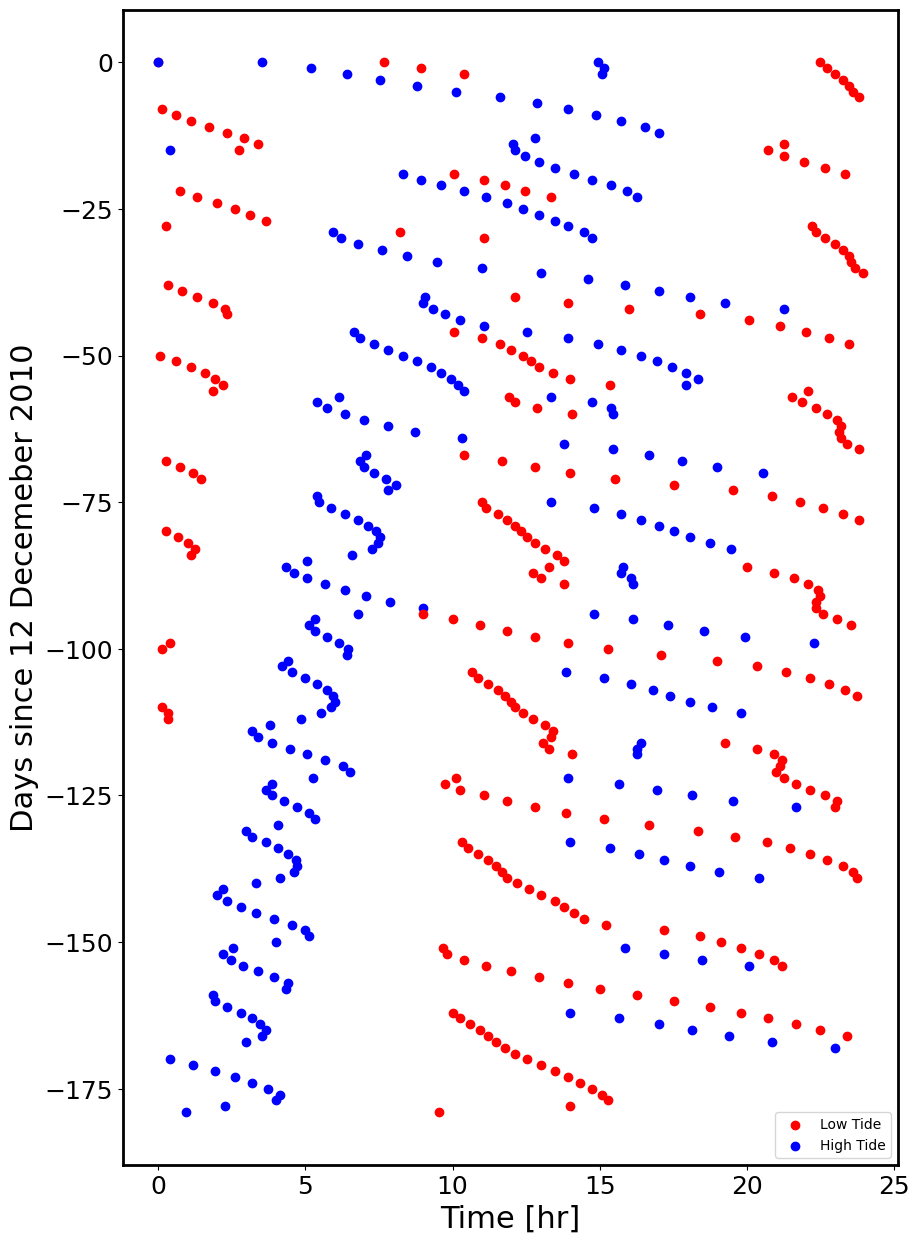

In [35]:
# There is a better way to do this because the list is sorted --> Now uses bisect!
import bisect

SEC_IN_HR = 3600
fig, ax = plt.subplots(figsize=[10, 15])
y_offset = 0
for i in range(len(dates[:182])):
    if i > 1:
        st_date = dates[i - 1]
        end_date = dates[i]
        lower = bisect.bisect_right(dist_gz05["vly_date"], st_date)
        upper = bisect.bisect_left(dist_gz05["vly_date"], end_date)
        to_plot = dist_gz05["vly_date"][lower:upper]

        to_plot = [
            datetime.timedelta(
                hours=x.time().hour, minutes=x.time().minute, seconds=x.time().second
            ).total_seconds()
            / SEC_IN_HR
            for x in to_plot
        ]
        y_val = y_offset * np.ones_like(to_plot)
        ax.scatter(to_plot, y_val, color="red")

        lower = bisect.bisect_right(dist_gz05["pk_date"], st_date)
        upper = bisect.bisect_left(dist_gz05["pk_date"], end_date)
        to_plot = dist_gz05["pk_date"][lower:upper]

        to_plot = [
            datetime.timedelta(
                hours=x.time().hour, minutes=x.time().minute, seconds=x.time().second
            ).total_seconds()
            / SEC_IN_HR
            for x in to_plot
        ]
        y_val = y_offset * np.ones_like(to_plot)
        ax.scatter(to_plot, y_val, color="blue")

        y_offset -= 1

ax.scatter(0, 0, color="red", label="Low Tide")
ax.scatter(0, 0, color="blue", label="High Tide")

ax.legend()
ax.set_xlabel("Time [hr]", size=22)
ax.set_ylabel("Days since 12 Decemeber 2010", size=22)
ax.xaxis.set_tick_params(labelsize=18)
ax.yaxis.set_tick_params(labelsize=18)

In [17]:
# Read .mat files from RossGNSS
from scipy.io import loadmat
import pandas as pd

folder = "/mnt/c/users/ZacharyKatz/Desktop/Research/TideEvents//RossGNSS"
data = loadmat(f"{folder}/TS_RS18_raw_30s.mat")

# Create a pandas dataframe
df = pd.DataFrame(data["DATA"])
df.columns = [
    "time",
    "dispNorth",
    "dispEast",
    "dispUp",
    "sNorth",
    "sEast",
    "sUp",
]  # Decimal day of year since 01/01/2015, meter, meter, meter, meter, meter, meter
df["time"] = pd.to_datetime(df["time"], unit="D", origin="2015-01-01")

print(df[150000:])

                                time   dispNorth  dispEast    dispUp  \
150000 2016-01-23 02:30:22.499998761   70.016295  0.929470 -0.261504   
150001 2016-01-23 02:30:52.500003572   70.015756  0.930409 -0.254592   
150002 2016-01-23 02:31:22.500001790   70.017354  0.925051 -0.237593   
150003 2016-01-23 02:31:52.500000000   70.024987  0.928685 -0.270139   
150004 2016-01-23 02:32:22.499998209   70.023815  0.927960 -0.258413   
...                              ...         ...       ...       ...   
345161 2016-03-30 21:24:52.500001567  161.263129  2.359356 -0.122087   
345162 2016-03-30 21:25:22.499999777  161.266420  2.355517 -0.123159   
345163 2016-03-30 21:25:52.499997986  161.264393  2.360165 -0.119057   
345164 2016-03-30 21:26:21.999998912  161.263835  2.362133 -0.123203   
345165 2016-03-30 21:26:36.000003445  161.264598  2.367247 -0.111925   

          sNorth     sEast       sUp  
150000  0.001711  0.002741  0.010198  
150001  0.001547  0.002914  0.010319  
150002  0.002917  

In [36]:
# Connect axes using https://matplotlib.org/stable/users/explain/text/annotations.html
from matplotlib.transforms import Bbox, TransformedBbox, blended_transform_factory

from mpl_toolkits.axes_grid1.inset_locator import (
    BboxPatch,
    BboxConnector,
    BboxConnectorPatch,
)


def connect_bbox(
    bbox1, bbox2, loc1a, loc2a, loc1b, loc2b, prop_lines, prop_patches=None
):
    if prop_patches is None:
        prop_patches = prop_lines.copy()
        prop_patches["alpha"] = prop_patches.get("alpha", 1) * 0.2

    c1 = BboxConnector(bbox1, bbox2, loc1=loc1a, loc2=loc2a, **prop_lines)
    c1.set_clip_on(False)
    c2 = BboxConnector(bbox1, bbox2, loc1=loc1b, loc2=loc2b, **prop_lines)
    c2.set_clip_on(False)

    bbox_patch1 = BboxPatch(bbox1, **prop_patches)
    bbox_patch2 = BboxPatch(bbox2, **prop_patches)

    p = BboxConnectorPatch(
        bbox1,
        bbox2,
        # loc1a=3, loc2a=2, loc1b=4, loc2b=1,
        loc1a=loc1a,
        loc2a=loc2a,
        loc1b=loc1b,
        loc2b=loc2b,
        **prop_patches,
    )
    p.set_clip_on(False)

    return c1, c2, bbox_patch1, bbox_patch2, p


def zoom_effect01(ax1, ax2, xmin, xmax, **kwargs):
    """
    ax1 : the main axes
    ax1 : the zoomed axes
    (xmin,xmax) : the limits of the colored area in both plot axes.

    connect ax1 & ax2. The x-range of (xmin, xmax) in both axes will
    be marked.  The keywords parameters will be used ti create
    patches.

    """

    trans1 = blended_transform_factory(ax1.transData, ax1.transAxes)
    trans2 = blended_transform_factory(ax2.transData, ax2.transAxes)

    bbox = Bbox.from_extents(xmin, 0, xmax, 1)

    mybbox1 = TransformedBbox(bbox, trans1)
    mybbox2 = TransformedBbox(bbox, trans2)

    prop_patches = kwargs.copy()
    prop_patches["ec"] = "none"
    prop_patches["alpha"] = 0.2

    c1, c2, bbox_patch1, bbox_patch2, p = connect_bbox(
        mybbox1,
        mybbox2,
        loc1a=3,
        loc2a=2,
        loc1b=4,
        loc2b=1,
        prop_lines=kwargs,
        prop_patches=prop_patches,
    )

    # ax1.add_patch(bbox_patch1)
    # ax2.add_patch(bbox_patch2)
    ax2.add_patch(c1)
    ax2.add_patch(c2)
    ax2.add_patch(p)

    return c1, c2, bbox_patch1, bbox_patch2, p

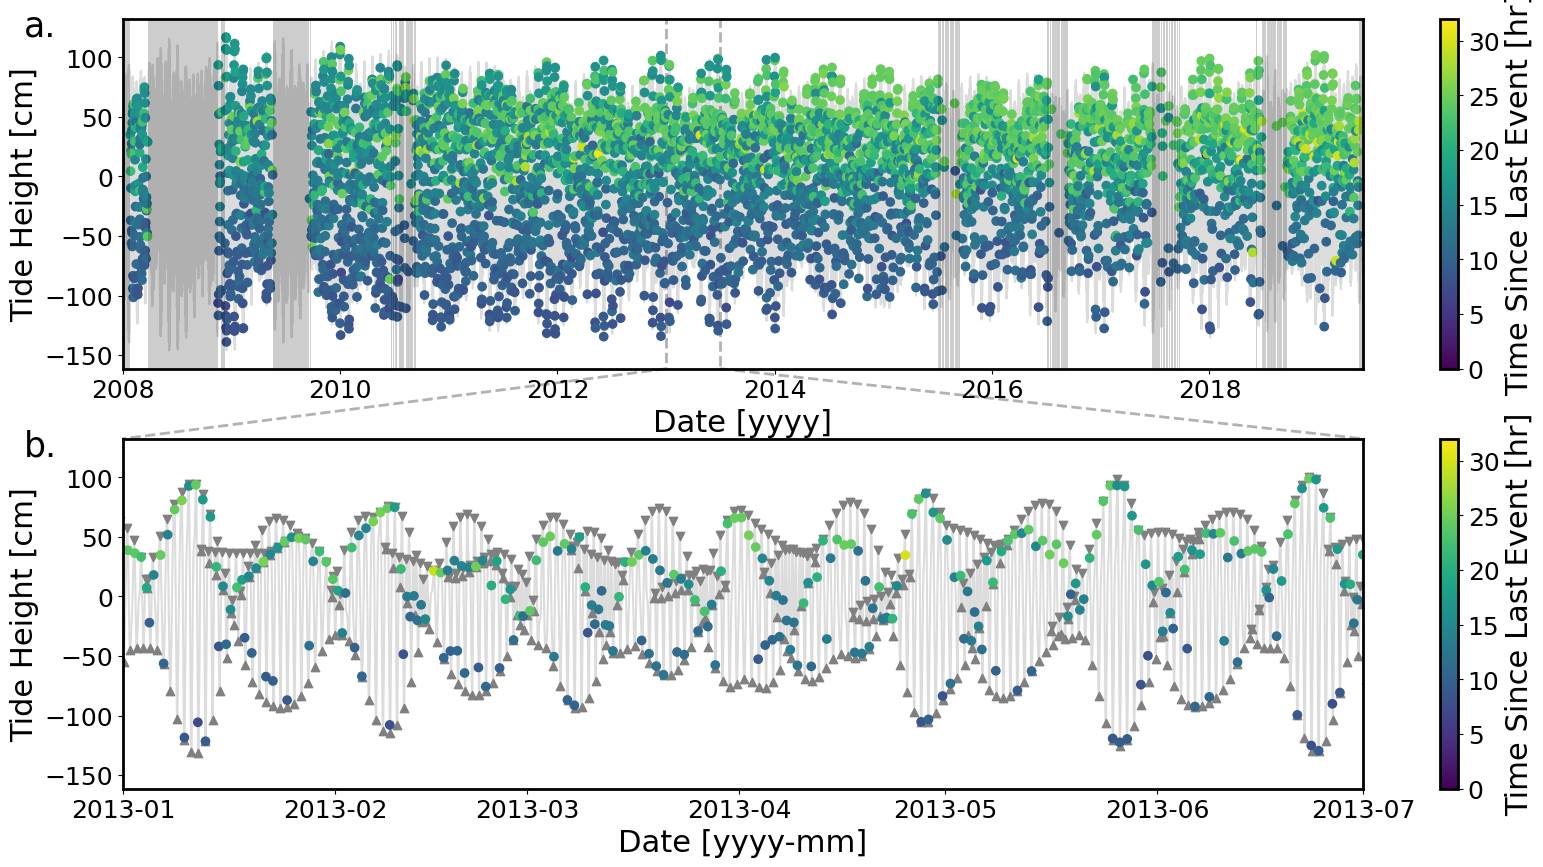

In [37]:
# Plot tides to see trends with diurnal tides
def subplot(ax, place, dist, st, ed, triangles=False):
    """Subplot for Figure 3. Plots tides and events colored by time since last event

    Parameters
    ----------
    ax : matplotlib.pyplot.axis
        Axis to plot on
    place : str
        Place tides are modeled at
    dist : dict
        Dict of high and low tides
    st : datetime.datetime
        Start time of panel
    ed : datetime.datetime
        End time of panel;
    triangles : bool, optional
        Flag to plot low and high tide triangles. Default is False.
    """
    ax.plot(dates_timeseries, ev_data[f"tides{place}"], zorder=0, color="gainsboro")
    if triangles:
        ax.scatter(dist["pk_date"], dist["pk_tide"], zorder=0, color="gray", marker="v")
        ax.scatter(
            dist["vly_date"], dist["vly_tide"], zorder=0, color="gray", marker="^"
        )
    hr_since_last_ev = [
        (a.days * 24 * 3600 + a.seconds) / 3600 for a in ev_data["time_since_last_ev"]
    ]
    masked_hr = np.ma.masked_where(np.array(hr_since_last_ev) > 32, ev_data["ev_time"])
    cax = ax.scatter(
        masked_hr,
        ev_data[f"tide_event_time_{place}"],
        c=hr_since_last_ev,
        zorder=2,
        cmap="viridis",
        vmin=0,
        vmax=32,
    )
    cbar = plt.colorbar(cax)
    cbar.set_label("Time Since Last Event [hr]", size=22)
    cbar.ax.tick_params(labelsize=18)
    ax.set_xlim(st, ed)
    # ax.set_xlim(datetime.datetime(2012,12,8),datetime.datetime(2013,5,20))
    ax.set_xlabel("Date [yyyy]", size=22)
    if triangles:
        ax.set_xlabel("Date [yyyy-mm]", size=22)
    ax.set_ylabel("Tide Height [cm]", size=22)
    ax.xaxis.set_tick_params(labelsize=18)
    ax.yaxis.set_tick_params(labelsize=18)

    for start, interval in zip(no_data["starts"][:], no_data["interval"][:]):
        start = datetime.datetime.strptime(start, "%Y-%m-%d %H:%M:%S")
        rect = plt.Rectangle(
            (start, -200), interval, 1000, facecolor="black", alpha=0.1, zorder=3
        )
        ax1.add_patch(rect)

    # ax.set_title(f'{place} Tide Reference',size=20)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=[20, 10])
st = datetime.datetime(2007, 12, 1)
ed = datetime.datetime(2019, 6, 17)

st = datetime.datetime(2008, 1, 1)
ed = datetime.datetime(2019, 6, 1)

subplot(ax1, "gz05", dist_gz05, st, ed, triangles=False)
st = datetime.datetime(2013, 1, 1)
ed = datetime.datetime(2013, 7, 1)
rect = plt.Rectangle(
    (st, -200),
    ed - st,
    1000,
    facecolor="none",
    zorder=0,
    alpha=0.3,
    edgecolor="black",
    linewidth=2,
    linestyle="--",
)
ax1.add_patch(rect)


# st = datetime.datetime(2015, 12, 3)
# ed = datetime.datetime(2015, 12, 11)

subplot(ax2, "gz05", dist_gz05, st, ed, triangles=True)
# ax3 = ax2.twinx()
# ax3.plot(df["time"], df["dispEast"], color="red")
# ax3.plot(df["time"], df["disp"], color="red")
ax1.annotate("a.", (-0.08, 0.95), xycoords="axes fraction", fontsize=25)
ax2.annotate("b.", (-0.08, 0.95), xycoords="axes fraction", fontsize=25)

zoom_effect01(
    ax1,
    ax2,
    mdates.date2num(st),
    mdates.date2num(ed),
    ec="black",
    lw=2,
    alpha=0.3,
    ls="--",
)

plt.show()
fig.tight_layout()

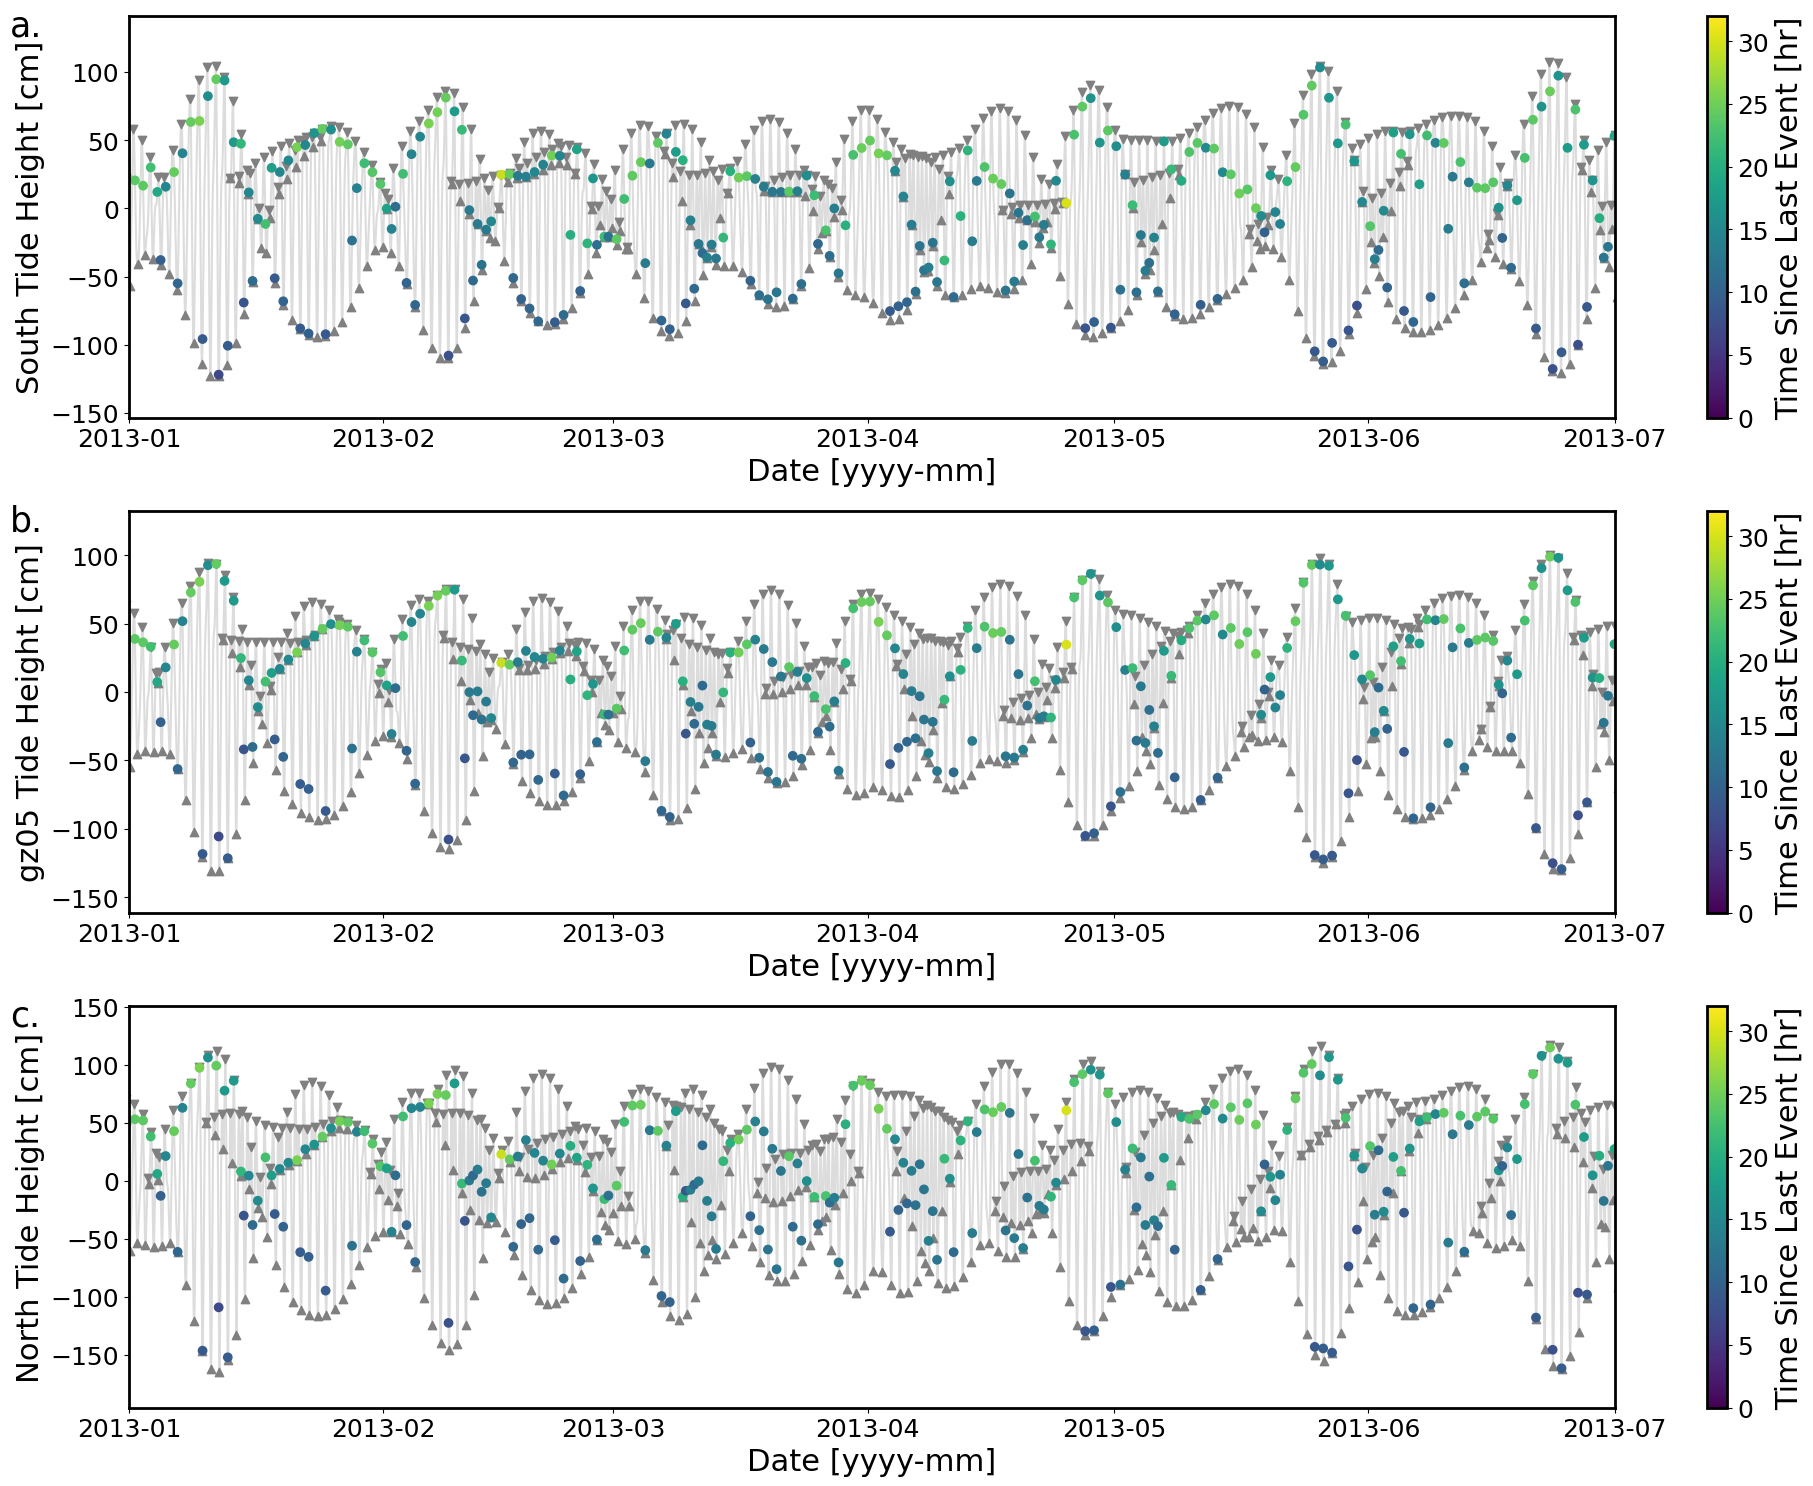

In [59]:
# Paper Figure SX
# Panel for tides at north, south, and middle of basin
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=[20, 15])
st = datetime.datetime(2013, 1, 1)
ed = datetime.datetime(2013, 7, 1)

subplot(ax1, "South", dist_South, st, ed, triangles=True)

subplot(ax2, "gz05", dist_gz05, st, ed, triangles=True)

subplot(ax3, "North", dist_North, st, ed, triangles=True)

ax1.set_ylabel("South Tide Height [cm]")
ax2.set_ylabel("gz05 Tide Height [cm]")
ax3.set_ylabel("North Tide Height [cm]")
ax1.annotate("a.", (-0.08, 0.95), xycoords="axes fraction", fontsize=25)
ax2.annotate("b.", (-0.08, 0.95), xycoords="axes fraction", fontsize=25)
ax3.annotate("c.", (-0.08, 0.95), xycoords="axes fraction", fontsize=25)
fig.tight_layout()

In [ ]:
# Plot tide locations


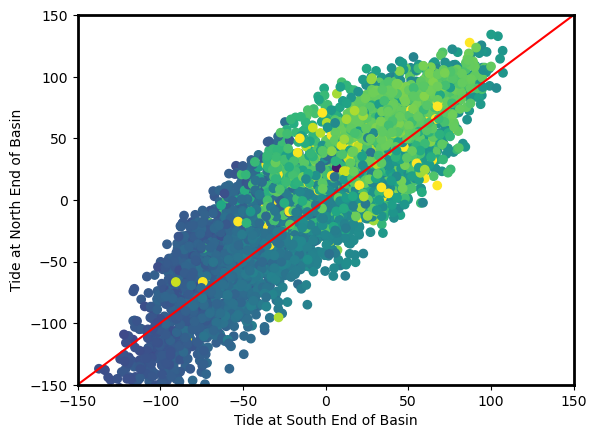

In [57]:
fig, ax = plt.subplots()
hr_since_last_ev = [
    (a.days * 24 * 3600 + a.seconds) / 3600 for a in ev_data["time_since_last_ev"]
]
masked_hr = np.ma.masked_where(np.array(hr_since_last_ev) > 32, ev_data["ev_time"])
cax = ax.scatter(
    ev_data["tide_event_time_South"],
    ev_data["tide_event_time_North"],
    c=hr_since_last_ev,
    zorder=2,
    cmap="viridis",
    vmin=0,
    vmax=32,
)

ax.set_xlabel("Tide at South End of Basin")
ax.set_ylabel("Tide at North End of Basin")
ax.set_xlim(-150, 150)
ax.set_ylim(-150, 150)
x = np.arange(-150, 250, 150)
y = np.arange(-150, 250, 150)
ax.plot(y, x, "red")

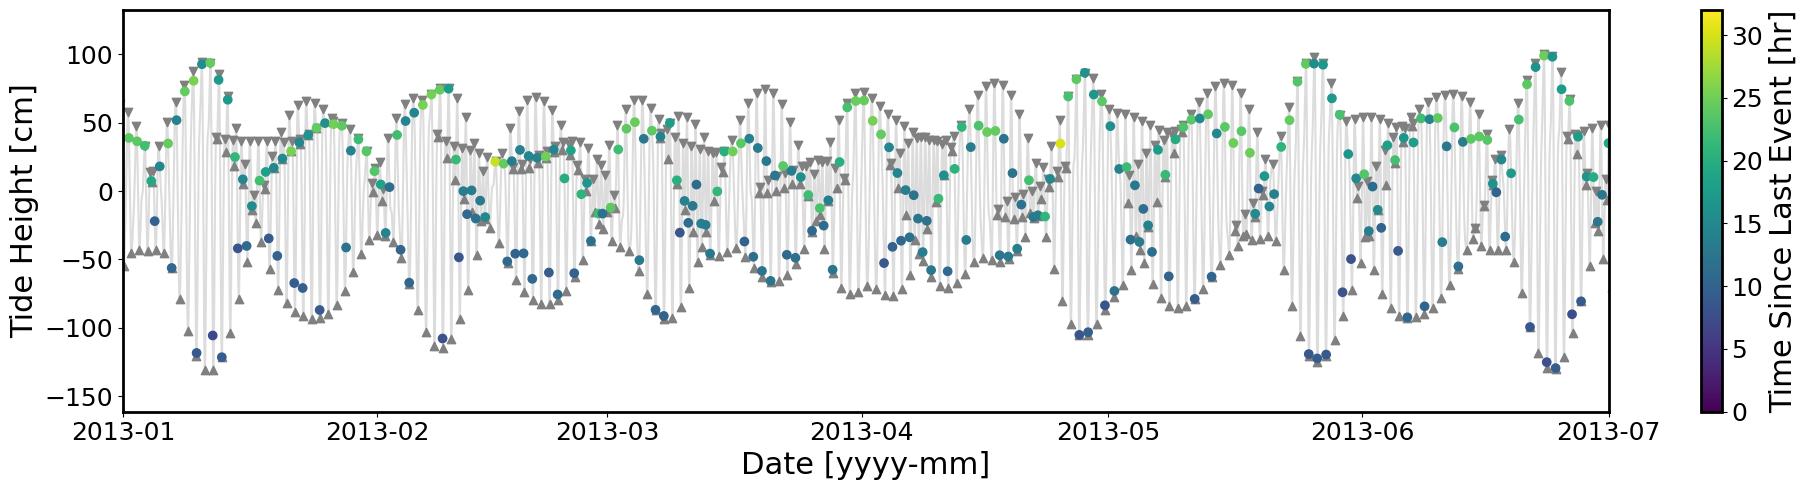

In [27]:
# FOR COMPS 1 PRESENTATION
# Plot tides to see trends with diurnal tides
def subplot(ax, place, dist, st, ed, triangles=False):
    """Subplot for Figure 3. Plots tides and events colored by time since last event

    Parameters
    ----------
    ax : matplotlib.pyplot.axis
        Axis to plot on
    place : str
        Place tides are modeled at
    dist : dict
        Dict of high and low tides
    st : datetime.datetime
        Start time of panel
    ed : datetime.datetime
        End time of panel;
    triangles : bool, optional
        Flag to plot low and high tide triangles. Default is False.
    """
    ax.plot(dates_timeseries, ev_data[f"tides{place}"], zorder=0, color="gainsboro")
    if triangles:
        ax.scatter(dist["pk_date"], dist["pk_tide"], zorder=0, color="gray", marker="v")
        ax.scatter(
            dist["vly_date"], dist["vly_tide"], zorder=0, color="gray", marker="^"
        )
    hr_since_last_ev = [
        (a.days * 24 * 3600 + a.seconds) / 3600 for a in ev_data["time_since_last_ev"]
    ]
    masked_hr = np.ma.masked_where(np.array(hr_since_last_ev) > 32, ev_data["ev_time"])
    cax = ax.scatter(
        masked_hr,
        ev_data[f"tide_event_time_{place}"],
        c=hr_since_last_ev,
        zorder=2,
        cmap="viridis",
        vmin=0,
        vmax=32,
        # alpha=0
    )
    cbar = plt.colorbar(cax)
    cbar.set_label("Time Since Last Event [hr]", size=22)
    cbar.ax.tick_params(labelsize=18)
    ax.set_xlim(st, ed)
    # ax.set_xlim(datetime.datetime(2012,12,8),datetime.datetime(2013,5,20))
    ax.set_xlabel("Date [yyyy]", size=22)
    if triangles:
        ax.set_xlabel("Date [yyyy-mm]", size=22)
    ax.set_ylabel("Tide Height [cm]", size=22)
    ax.xaxis.set_tick_params(labelsize=18)
    ax.yaxis.set_tick_params(labelsize=18)
    for start, interval in zip(no_data["starts"][:], no_data["interval"][:]):
        start = datetime.datetime.strptime(start, "%Y-%m-%d %H:%M:%S")
        rect = plt.Rectangle(
            (start, -200), interval, 1000, facecolor="black", alpha=0.1, zorder=3
        )
        ax1.add_patch(rect)

    # ax.set_title(f'{place} Tide Reference',size=20)


fig, ax2 = plt.subplots(1, 1, figsize=[20, 5])
st = datetime.datetime(2007, 12, 1)
ed = datetime.datetime(2019, 6, 17)

st = datetime.datetime(2008, 1, 1)
ed = datetime.datetime(2019, 6, 1)

# subplot(ax1, "gz05", dist_gz05, st, ed, triangles=False)
st = datetime.datetime(2013, 1, 1)
ed = datetime.datetime(2013, 7, 1)

# st = datetime.datetime(2015, 12, 3)
# ed = datetime.datetime(2015, 12, 11)

subplot(ax2, "gz05", dist_gz05, st, ed, triangles=True)
# ax3 = ax2.twinx()
# ax3.plot(df["time"], df["dispEast"], color="red")
# ax3.plot(df["time"], df["disp"], color="red")
fig.tight_layout()

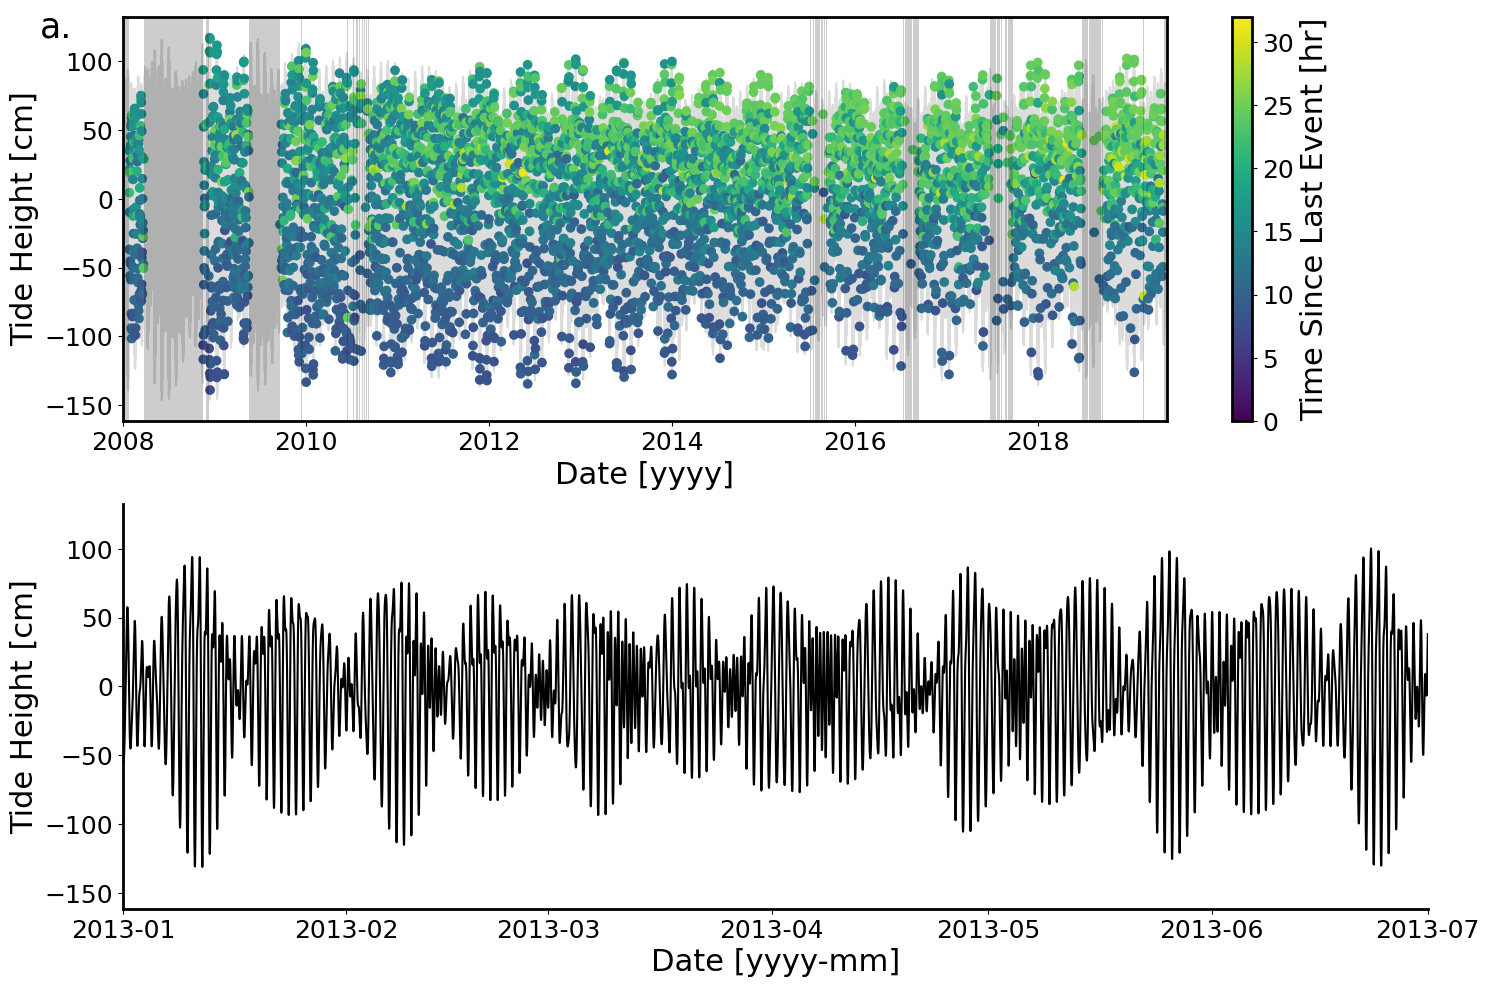

In [15]:
# Plot tides to see trends with diurnal tides
def pressubplot(ax, place, dist, st, ed, triangles=False):
    """Subplot for Figure 3. Plots tides and events colored by time since last event

    Parameters
    ----------
    ax : matplotlib.pyplot.axis
        Axis to plot on
    place : str
        Place tides are modeled at
    dist : dict
        Dict of high and low tides
    st : datetime.datetime
        Start time of panel
    ed : datetime.datetime
        End time of panel;
    triangles : bool, optional
        Flag to plot low and high tide triangles. Default is False.
    """
    ax.plot(dates_timeseries, ev_data[f"tides{place}"], zorder=0, color="k")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xlim(st, ed)
    # ax.set_xlim(datetime.datetime(2012,12,8),datetime.datetime(2013,5,20))
    ax.set_xlabel("Date [yyyy]", size=22)
    if triangles:
        ax.set_xlabel("Date [yyyy-mm]", size=22)
    ax.set_ylabel("Tide Height [cm]", size=22)
    ax.xaxis.set_tick_params(labelsize=18)
    ax.yaxis.set_tick_params(labelsize=18)

    for start, interval in zip(no_data["starts"][:], no_data["interval"][:]):
        start = datetime.datetime.strptime(start, "%Y-%m-%d %H:%M:%S")
        rect = plt.Rectangle(
            (start, -200), interval, 1000, facecolor="black", alpha=0.1, zorder=3
        )
        ax1.add_patch(rect)

    # ax.set_title(f'{place} Tide Reference',size=20)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=[15, 10])
st = datetime.datetime(2007, 12, 1)
ed = datetime.datetime(2019, 6, 17)

st = datetime.datetime(2008, 1, 1)
ed = datetime.datetime(2019, 6, 1)

subplot(ax1, "gz05", dist_gz05, st, ed, triangles=False)
st = datetime.datetime(2013, 1, 1)
ed = datetime.datetime(2013, 7, 1)

# st = datetime.datetime(2015, 12, 3)
# ed = datetime.datetime(2015, 12, 11)

pressubplot(ax2, "gz05", dist_gz05, st, ed, triangles=True)
# ax3 = ax2.twinx()
# ax3.plot(df["time"], df["dispEast"], color="red")
# ax3.plot(df["time"], df["disp"], color="red")
ax1.annotate("a.", (-0.08, 0.95), xycoords="axes fraction", fontsize=25)
# ax2.annotate("b.", (-0.08, 0.95), xycoords="axes fraction", fontsize=25)
fig.tight_layout()

In [14]:
# Find time since last event for all skipped low tides
time_since_last_event_low_pk = []
time_to_next_event_low_pk = []

events = np.ma.masked_where(
    np.array(dist_gz05["high_closers"]) == 1, ev_data["ev_time"]
)
events = np.ma.compressed(events)
tide_low = np.ma.masked_where(
    np.array(dist_gz05["high_closers"]) == 1, ev_data["tide_event_time_gz05"]
)
tide_low = np.ma.compressed(tide_low)

for i, valley in enumerate(dist_gz05["vly_date"]):
    closest_event = min(
        events,
        key=lambda d: abs(datetime.datetime.strptime(d, "%Y-%m-%d %H:%M:%S") - valley),
    )
    if datetime.datetime.strptime(closest_event, "%Y-%m-%d %H:%M:%S") > valley:
        closest_event = events[np.where(events == closest_event)[0] - 1][0]
    time_since_last_event_low_pk.append(
        valley - datetime.datetime.strptime(closest_event, "%Y-%m-%d %H:%M:%S")
    )

    closest_event = min(
        events,
        key=lambda d: abs(datetime.datetime.strptime(d, "%Y-%m-%d %H:%M:%S") - valley),
    )
    if datetime.datetime.strptime(closest_event, "%Y-%m-%d %H:%M:%S") < valley:
        try:
            closest_event = events[np.where(events == closest_event)[0] + 1][0]
        except IndexError:
            pass
    time_to_next_event_low_pk.append(
        datetime.datetime.strptime(closest_event, "%Y-%m-%d %H:%M:%S") - valley
    )

In [15]:
def rolling_average(
    window,
    slide_len,
    time_since_last_event_low_pk,
    time_to_next_event_low_pk,
    dist_gz05,
    ev_data,
    no_data,
):
    """Rolling average of slip events.

    Parameters
    ----------
    window : int
        Days to average over
    slide_len : int
        Days to slide window
    time_since_last_event_low_pk : list
        Times since last event
    time_to_next_event_low_pk : list
        Time to next event
    dist_gz05 : dict
        Dict of high and low tides
    ev_data : dict
        Dict of event data
    no_data : dict
        Dict of no data times
    """
    # Compute rolling average of skipped low slips

    time_since_low_hr = [a.total_seconds() / 3600 for a in time_since_last_event_low_pk]
    time_to_low_hr = [a.total_seconds() / 3600 for a in time_to_next_event_low_pk]

    mask = []
    for ts, tt in zip(time_since_low_hr, time_to_low_hr):
        if ts < 6 or tt < 6:
            mask.append(1)
        else:
            mask.append(0)

    masked_low_skips = np.ma.masked_where(mask, dist_gz05["vly_date"])
    masked_low_skips = np.ma.compressed(masked_low_skips)

    dates_timeseries_avg = []
    initial_time = datetime.datetime.strptime(
        "2007-12-01 00:00:00", "%Y-%m-%d %H:%M:%S"
    )

    time_to_append = window  # Days
    slide = slide_len  # Days

    # assert time_to_append % slide == 0
    interval = int(time_to_append // slide)  # MUST BE AN INTEGER

    rng = int(12 * 365 // slide)  # Range of times
    for i in range(rng):
        dates_timeseries_avg.append(initial_time + datetime.timedelta(days=slide * i))

    skips = []
    skip_starts = []
    skip_ends = []
    skip_middles = []
    tot_slips = []
    spacings = []

    for i, date in enumerate(dates_timeseries_avg):
        if i > interval:
            interval_start = dates_timeseries_avg[i - interval]
            interval_end = date

            # print(interval_start,interval_end)
            last_ev = datetime.datetime.strptime(
                ev_data["ev_time"].iloc[-1], "%Y-%m-%d %H:%M:%S"
            )
            first_ev = datetime.datetime.strptime(
                ev_data["ev_time"].iloc[0], "%Y-%m-%d %H:%M:%S"
            )
            stop = False
            for start, end in zip(no_data["starts"], no_data["ends"]):
                start = datetime.datetime.strptime(start, "%Y-%m-%d %H:%M:%S")
                end = datetime.datetime.strptime(end, "%Y-%m-%d %H:%M:%S")

                # Check that interval does not include gaps in data or start before 1st event or end after last event
                # if (interval_start > start and interval_start < end) or (interval_end > start and interval_end < end) \
                #    or (interval_start < end and interval_end > start) or (interval_start < start and interval_end > start) \
                #        or interval_start < first_ev \
                #        or interval_end > last_ev:
                #    stop = True

                if (
                    (interval_start < end and interval_end > start)
                    or interval_start < first_ev
                    or interval_end > last_ev
                ):
                    stop = True

            if not stop:
                # Number of total events
                slip = 0
                for event in ev_data["ev_time"]:
                    event = datetime.datetime.strptime(event, "%Y-%m-%d %H:%M:%S")
                    if event > interval_start and event < interval_end:
                        slip += 1

                # Number of low skips
                skip = 0
                for date_low in masked_low_skips:
                    if date_low > interval_start and date_low < interval_end:
                        skip += 1

                # Avg Event spacing
                spacing = 0
                counter = 0
                time_since = [
                    (a.days * 24 * 3600 + a.seconds) / 3600
                    for a in ev_data["time_since_last_ev"]
                ]
                for f, event in enumerate(ev_data["ev_time"]):
                    event = datetime.datetime.strptime(event, "%Y-%m-%d %H:%M:%S")
                    if event > interval_start and event < interval_end:
                        spacing += time_since[f]
                        counter += 1
                try:
                    spacing = spacing / counter
                except ZeroDivisionError:
                    spacing = np.nan
                # Avg Event amplitude

            else:
                skip = np.nan
                slip = np.nan
                spacing = np.nan

            skip_starts.append(interval_start)
            skip_ends.append(interval_end)
            skip_middles.append(interval_start + (interval_end - interval_start) / 2)
            skips.append(skip)
            tot_slips.append(slip)
            spacings.append(spacing)

    return skip_starts, skip_ends, skip_middles, skips, tot_slips, spacings

In [16]:
def annotation(ax, x1, x2, y1, y2, text):
    """Draws an annotated bracket."""
    xs = [x1, x1, x2, x2]
    ys = [y1, y2, y2, y1]
    ax.plot(xs, ys, "k-")
    ax.text((x2 - x1) / 2 + x1, y2 + 0.1, text, ha="center", va="bottom", fontsize=18)

In [17]:
# Plotting function
def plot_rolling_avg_mm(
    window, slide_len, skip_starts, skip_ends, skip_middles, skips, tot_slips, spacings
):
    # Skipped slips by number of slips in xx period

    fig, (ax1, ax3) = plt.subplots(2, figsize=(20, 12))
    ax2 = ax1.twinx()
    (
        ax1.plot(
            dates_timeseries, ev_data["tidesgz05"], zorder=1, color="gray", alpha=0.4
        ),
    )
    for start, interval in zip(no_data["starts"][:], no_data["interval"][:]):
        start = datetime.datetime.strptime(start, "%Y-%m-%d %H:%M:%S")
        rect = plt.Rectangle(
            (start, -200), interval, 1000, facecolor="black", alpha=0.2, zorder=3
        )
        ax1.add_patch(rect)

    ax1.set_xlim(datetime.datetime(2008, 12, 8), datetime.datetime(2019, 5, 20))
    ax1.set_ylim(20, 130)
    ax1.set_ylim(-5, 5)

    xerr = [(end - start) // 2 for start, end in zip(skip_starts, skip_ends)]
    ax2.errorbar(skip_middles, tot_slips, xerr=xerr, fmt="o", color="black", zorder=2)
    # ax2.plot(skip_middles, tot_slips, color='blue')

    timestamps = [a.timestamp() for a in skip_middles]

    compressed_tot_slips = np.ma.masked_invalid(tot_slips)
    compressed_timestamps = np.ma.masked_where(
        np.ma.getmask(compressed_tot_slips), timestamps
    )
    compressed_tot_slips = np.ma.compressed(compressed_tot_slips)
    compressed_timestamps = np.ma.compressed(compressed_timestamps)

    coef = np.polyfit(compressed_timestamps, compressed_tot_slips, 1)
    print(coef)
    lst_sqrs_fit = np.poly1d(coef)
    print(lst_sqrs_fit[1])

    datetimes = [datetime.datetime.fromtimestamp(a) for a in compressed_timestamps]
    # ax2.plot(datetimes, lst_sqrs_fit(compressed_timestamps),color='blue',zorder=3)

    # Just a line so manually extract slope
    delta_y = (
        lst_sqrs_fit(compressed_timestamps)[-1] - lst_sqrs_fit(compressed_timestamps)[0]
    )
    delta_x = datetimes[-1] - datetimes[0]

    print(delta_y, delta_x)
    slope = delta_y / delta_x.total_seconds() * 3600 * 24 * 365
    print(slope)  # Slips / year
    ax1.yaxis.set_label_position("right")
    ax1.yaxis.tick_right()
    ax2.yaxis.set_label_position("left")
    ax2.yaxis.tick_left()
    ax1.set_xlabel("Date [yyyy]", size=22)
    ax1.set_ylabel("Tide Height [cm]", size=22)
    ax2.set_ylabel(f"Slips [{window} Day Rolling Avg]", size=22, color="black")
    ax1.xaxis.set_tick_params(labelsize=18)
    ax1.yaxis.set_tick_params(labelsize=18, color="gray")
    ax2.yaxis.set_tick_params(labelsize=18, colors="black")
    # ax2.spines['left'].set_color('red')

    ax4 = ax3.twinx()
    (
        ax3.plot(
            dates_timeseries, ev_data["tidesgz05"], zorder=1, color="gray", alpha=0.4
        ),
    )
    for start, interval in zip(no_data["starts"][:], no_data["interval"][:]):
        start = datetime.datetime.strptime(start, "%Y-%m-%d %H:%M:%S")
        rect = plt.Rectangle(
            (start, -200), interval, 1000, facecolor="black", alpha=0.2, zorder=3
        )
        ax3.add_patch(rect)

    ax3.set_xlim(datetime.datetime(2013, 1, 1), datetime.datetime(2014, 1, 1))
    # ax3.set_xlim(datetime.datetime(2008,12,8),datetime.datetime(2009,7,1))
    ax3.set_ylim(-155, 130)
    ax3.set_ylim(-5, 5)

    xerr = [(end - start) // 2 for start, end in zip(skip_starts, skip_ends)]
    ax4.errorbar(skip_middles, tot_slips, xerr=xerr, fmt="o", color="black", zorder=2)

    ax3.yaxis.set_label_position("right")
    ax3.yaxis.tick_right()
    ax4.yaxis.set_label_position("left")
    ax4.yaxis.tick_left()
    ax3.set_xlabel("Date [yyyy-mm]", size=22)
    ax3.set_ylabel("Tide Height [cm]", size=22)
    ax4.set_ylabel(f"Slips [{window} Day Rolling Avg]", size=22, color="black")
    ax3.xaxis.set_tick_params(labelsize=18)
    ax3.yaxis.set_tick_params(labelsize=18, color="gray")
    ax4.yaxis.set_tick_params(labelsize=18, colors="black")

    ssa_time = datetime.timedelta(days=182.63)
    ssa_start = datetime.datetime(2014, 3, 1)
    annotation(ax1, ssa_start, ssa_start + ssa_time, 3.5, 4, "$S_{sa}$")

    mm_time = datetime.timedelta(days=27.55)
    mm_start = datetime.datetime(2013, 5, 1)
    annotation(ax3, mm_start, mm_start + mm_time, 3.5, 4, "$M_{m}$")

    # ax1.set_title(f'{time_to_append} Day Rolling Average',size=22)

    ax1.set_title(f"{window} Day Rolling Average", size=22)
    fig.tight_layout()

In [18]:
# Plotting function
def plot_rolling_avg(
    window, slide_len, skip_starts, skip_ends, skip_middles, skips, tot_slips, spacings
):
    # Skipped slips by number of slips in xx period

    fig, (ax1, ax3) = plt.subplots(2, figsize=(20, 12))
    ax2 = ax1.twinx()
    (
        ax1.plot(
            dates_timeseries, ev_data["tidesgz05"], zorder=1, color="gray", alpha=0.4
        ),
    )
    for start, interval in zip(no_data["starts"][:], no_data["interval"][:]):
        start = datetime.datetime.strptime(start, "%Y-%m-%d %H:%M:%S")
        rect = plt.Rectangle(
            (start, -200), interval, 1000, facecolor="black", alpha=0.2, zorder=3
        )
        ax1.add_patch(rect)

    ax1.set_xlim(datetime.datetime(2007, 12, 1), datetime.datetime(2019, 6, 17))
    ax1.set_xlim(datetime.datetime(2008, 1, 1), datetime.datetime(2019, 6, 1))
    ax1.set_ylim(-120, 130)

    xerr = [(end - start) // 2 for start, end in zip(skip_starts, skip_ends)]
    ax2.errorbar(skip_middles, tot_slips, xerr=xerr, fmt="o", color="black", zorder=2)
    # ax2.plot(skip_middles, tot_slips, color='blue')

    timestamps = [a.timestamp() for a in skip_middles]

    compressed_tot_slips = np.ma.masked_invalid(tot_slips)
    compressed_timestamps = np.ma.masked_where(
        np.ma.getmask(compressed_tot_slips), timestamps
    )
    compressed_tot_slips = np.ma.compressed(compressed_tot_slips)
    compressed_timestamps = np.ma.compressed(compressed_timestamps)

    coef = np.polyfit(compressed_timestamps, compressed_tot_slips, 1)
    print(coef)
    lst_sqrs_fit = np.poly1d(coef)
    print(lst_sqrs_fit[1])

    datetimes = [datetime.datetime.fromtimestamp(a) for a in compressed_timestamps]
    # ax2.plot(datetimes, lst_sqrs_fit(compressed_timestamps),color='blue',zorder=3)

    # Just a line so manually extract slope
    delta_y = (
        lst_sqrs_fit(compressed_timestamps)[-1] - lst_sqrs_fit(compressed_timestamps)[0]
    )
    delta_x = datetimes[-1] - datetimes[0]

    print(delta_y, delta_x)
    slope = delta_y / delta_x.total_seconds() * 3600 * 24 * 365
    print(slope)  # Slips / year
    ax1.yaxis.set_label_position("right")
    ax1.yaxis.tick_right()
    ax2.yaxis.set_label_position("left")
    ax2.yaxis.tick_left()
    ax1.set_xlabel("Date [yyyy]", size=22)
    ax1.set_ylabel("Tide Height [cm]", size=22)
    ax2.set_ylabel(f"Slips [{window} Day Rolling Sum]", size=22, color="black")
    ax1.xaxis.set_tick_params(labelsize=18)
    ax1.yaxis.set_tick_params(labelsize=18, color="gray")
    ax2.yaxis.set_tick_params(labelsize=18, colors="black")
    # ax2.spines['left'].set_color('red')

    ax4 = ax3.twinx()
    (
        ax3.plot(
            dates_timeseries, ev_data["tidesgz05"], zorder=1, color="gray", alpha=0.4
        ),
    )
    for start, interval in zip(no_data["starts"][:], no_data["interval"][:]):
        start = datetime.datetime.strptime(start, "%Y-%m-%d %H:%M:%S")
        rect = plt.Rectangle(
            (start, -200), interval, 1000, facecolor="black", alpha=0.2, zorder=3
        )
        ax3.add_patch(rect)

    ax3.set_xlim(datetime.datetime(2014, 1, 1), datetime.datetime(2015, 6, 1))
    # ax3.set_xlim(datetime.datetime(2008,12,8),datetime.datetime(2009,7,1))
    ax3.set_ylim(-155, 130)

    xerr = [(end - start) // 2 for start, end in zip(skip_starts, skip_ends)]
    ax4.errorbar(skip_middles, tot_slips, xerr=xerr, fmt="o", color="black", zorder=2)

    ax3.yaxis.set_label_position("right")
    ax3.yaxis.tick_right()
    ax4.yaxis.set_label_position("left")
    ax4.yaxis.tick_left()
    ax3.set_xlabel("Date [yyyy-mm]", size=22)
    ax3.set_ylabel("Tide Height [cm]", size=22)
    ax4.set_ylabel(f"Slips [{window} Day Rolling Sum]", size=22, color="black")
    ax3.xaxis.set_tick_params(labelsize=18)
    ax3.yaxis.set_tick_params(labelsize=18, color="gray")
    ax4.yaxis.set_tick_params(labelsize=18, colors="black")

    ssa_time = datetime.timedelta(days=182.63)
    ssa_start = datetime.datetime(2014, 3, 1)
    annotation(ax1, ssa_start, ssa_start + ssa_time, 88, 92, "$S_{sa}$")

    mm_time = datetime.timedelta(days=27.55)
    mm_start = datetime.datetime(2014, 2, 20)
    annotation(ax3, mm_start, mm_start + mm_time, 80, 84, "$M_{m}$")

    # ax1.set_title(f'{time_to_append} Day Rolling Average',size=22)

    ax1.set_title(f"{window} Day Rolling Sum", size=22)
    fig.tight_layout()

In [19]:
slide = 1
rolling_avg_dicts = []
for window in [3, 27, 45]:
    skip_starts, skip_ends, skip_middles, skips, tot_slips, spacings = rolling_average(
        window,
        slide,
        time_since_last_event_low_pk,
        time_to_next_event_low_pk,
        dist_gz05,
        ev_data,
        no_data,
    )
    # Save as dict
    rolling_avg_dict = {
        "skip_starts": skip_starts,
        "skip_ends": skip_ends,
        "skip_middles": skip_middles,
        "skips": skips,
        "tot_slips": tot_slips,
        "spacings": spacings,
    }
    rolling_avg_dicts.append(rolling_avg_dict)

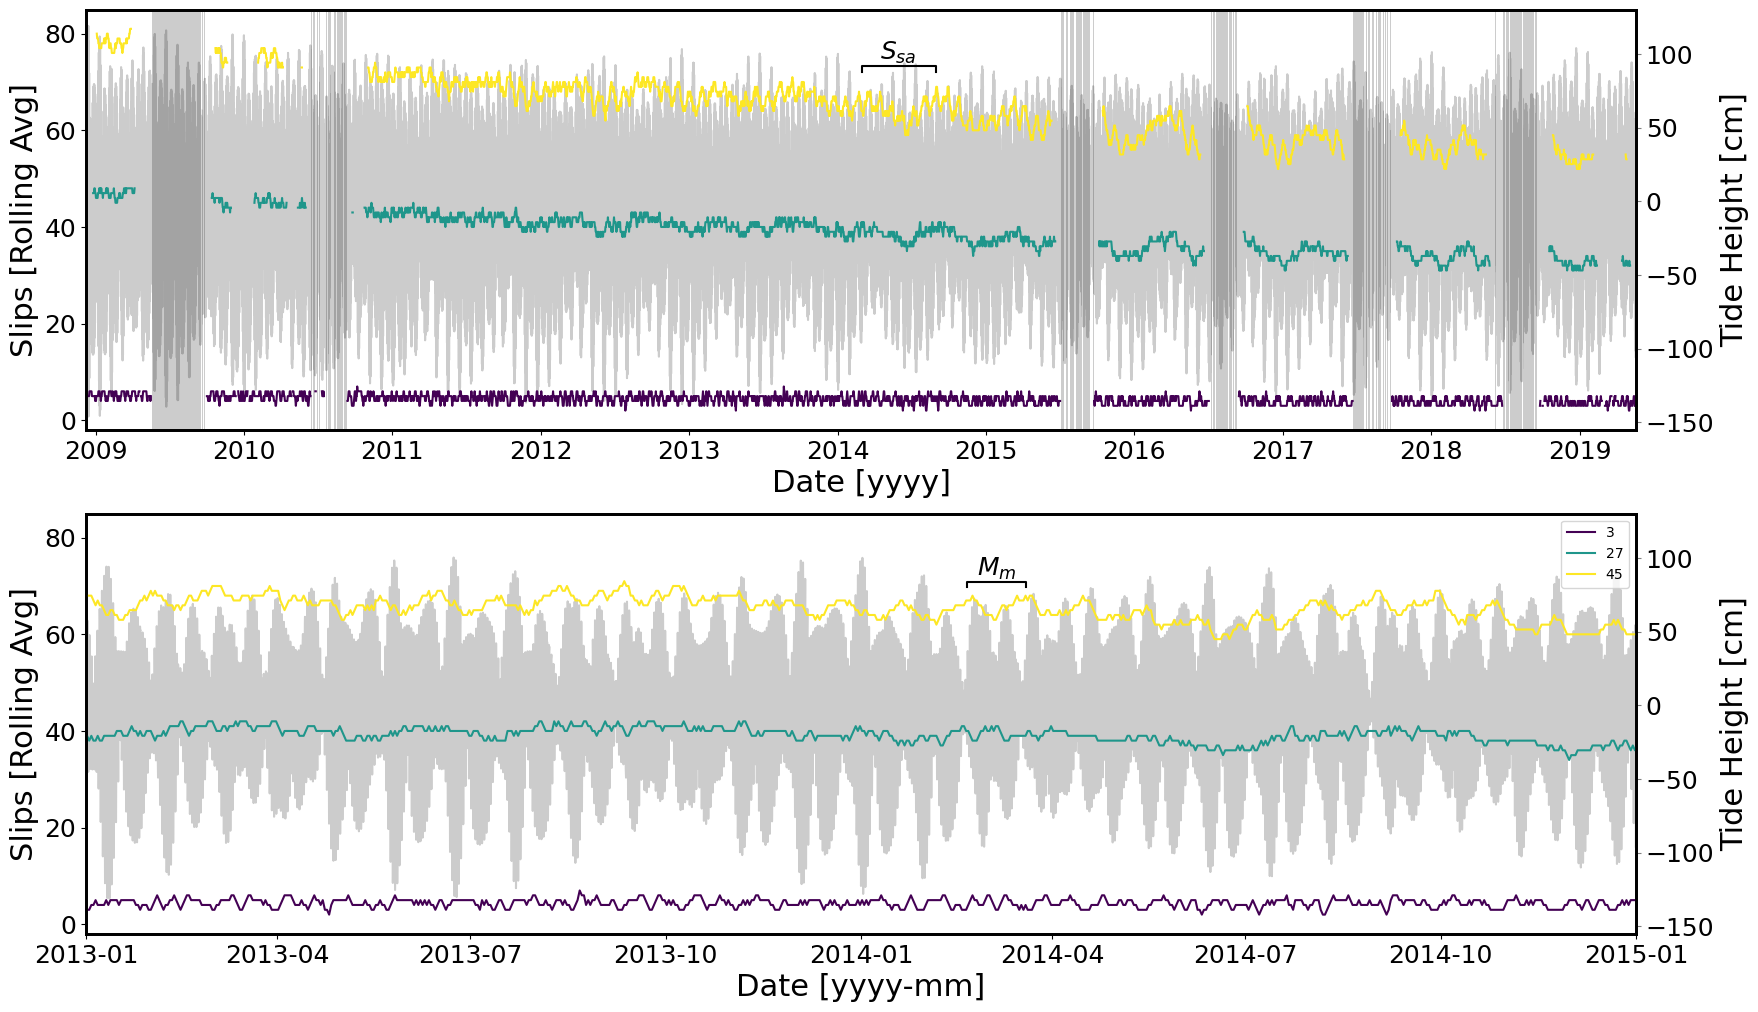

In [ ]:
# Plot all rolling averages on one plot
viridis = mpl.colormaps["viridis"].resampled(20)
fig, (ax1, ax3) = plt.subplots(2, figsize=(20, 12))
ax2 = ax1.twinx()
(ax1.plot(dates_timeseries, ev_data["tidesgz05"], zorder=1, color="gray", alpha=0.4),)
for start, interval in zip(no_data["starts"][:], no_data["interval"][:]):
    start = datetime.datetime.strptime(start, "%Y-%m-%d %H:%M:%S")
    rect = plt.Rectangle(
        (start, -200), interval, 1000, facecolor="black", alpha=0.2, zorder=3
    )
    ax1.add_patch(rect)

ax1.set_xlim(datetime.datetime(2008, 12, 8), datetime.datetime(2019, 5, 20))
ax1.set_ylim(-155, 130)

ax4 = ax3.twinx()
(ax3.plot(dates_timeseries, ev_data["tidesgz05"], zorder=1, color="gray", alpha=0.4),)
for start, interval in zip(no_data["starts"][:], no_data["interval"][:]):
    start = datetime.datetime.strptime(start, "%Y-%m-%d %H:%M:%S")
    rect = plt.Rectangle(
        (start, -200), interval, 1000, facecolor="black", alpha=0.2, zorder=3
    )
    ax3.add_patch(rect)

ax3.set_xlim(datetime.datetime(2013, 1, 1), datetime.datetime(2015, 1, 1))
ax3.set_ylim(-155, 130)

colors = np.linspace(0, 1, len(rolling_avg_dicts))
for i, (rolling_avg_dict, color) in enumerate(zip(rolling_avg_dicts, colors)):
    if i < 10:
        clr = viridis(color)
        skip_starts = rolling_avg_dict["skip_starts"]
        skip_ends = rolling_avg_dict["skip_ends"]
        skip_middles = rolling_avg_dict["skip_middles"]
        tot_slips = rolling_avg_dict["tot_slips"]
        window = rolling_avg_dict["window"]
        xerr = [(end - start) // 2 for start, end in zip(skip_starts, skip_ends)]
        ax2.plot(skip_middles, tot_slips, color=clr)
        ax4.plot(skip_middles, tot_slips, color=clr, label=f"{window}")
        # ax2.errorbar(skip_middles, tot_slips,xerr=xerr,fmt='o',color=clr,zorder=2)
        # ax4.errorbar(skip_middles, tot_slips,xerr=xerr,fmt='o',color=clr,zorder=2)

ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()
ax2.yaxis.set_label_position("left")
ax2.yaxis.tick_left()
ax1.set_xlabel("Date [yyyy]", size=22)
ax1.set_ylabel("Tide Height [cm]", size=22)
ax2.set_ylabel("Slips [Rolling Avg]", size=22, color="black")
ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18, color="gray")
ax2.yaxis.set_tick_params(labelsize=18, colors="black")

ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()
ax4.yaxis.set_label_position("left")
ax4.yaxis.tick_left()
ax3.set_xlabel("Date [yyyy-mm]", size=22)
ax3.set_ylabel("Tide Height [cm]", size=22)
ax4.set_ylabel("Slips [Rolling Avg]", size=22, color="black")
ax3.xaxis.set_tick_params(labelsize=18)
ax3.yaxis.set_tick_params(labelsize=18, color="gray")
ax4.yaxis.set_tick_params(labelsize=18, colors="black")
ax4.legend()


ssa_time = datetime.timedelta(days=182.63)
ssa_start = datetime.datetime(2014, 3, 1)
annotation(ax1, ssa_start, ssa_start + ssa_time, 88, 92, "$S_{sa}$")

mm_time = datetime.timedelta(days=27.55)
mm_start = datetime.datetime(2014, 2, 20)
annotation(ax3, mm_start, mm_start + mm_time, 80, 84, "$M_{m}$")

In [20]:
# Plot TIDE lomb scargles
SEC_TO_DAY = 3600 * 24
SEC_TO_HR = 3600
xlim = 450

slide = 1
dates_as_sec = [
    a.timestamp() - dates_timeseries[0].timestamp() for a in dates_timeseries
]
tides = ev_data[f"tides{place}"]

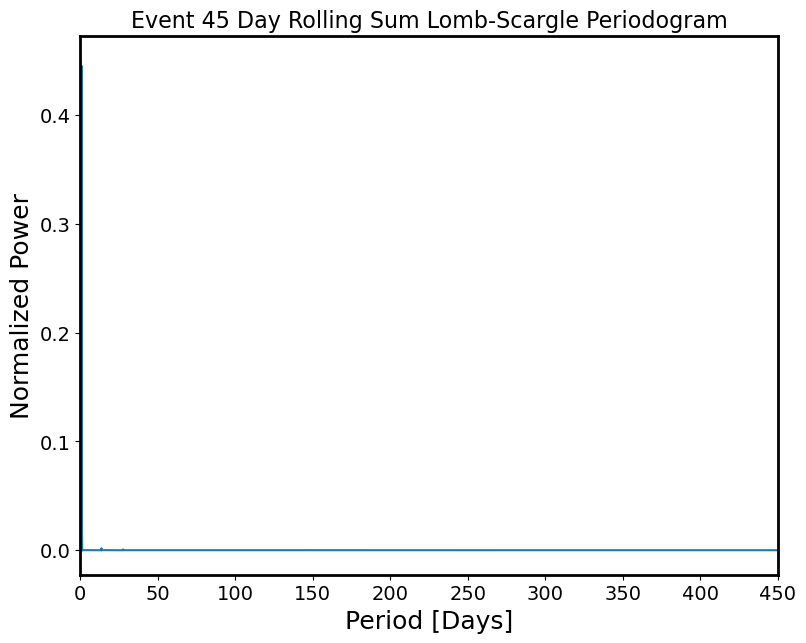

In [48]:
frequency, power = LombScargle(dates_as_sec, tides).autopower()

pks = scipy.signal.find_peaks(power[:10000], height=0.06)[0]
fig, ax = plt.subplots(figsize=(9, 7))
# ax.plot(frequency[pks], power[pks], 'ro')
period = 1 / frequency / SEC_TO_DAY  # Days
ax.plot(period, power)
ax.set_title(f"Event {window} Day Rolling Sum Lomb-Scargle Periodogram", fontsize=16)
ax.set_xlabel("Period [Days]", fontsize=18)
ax.set_ylabel("Normalized Power", fontsize=18)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_xlim(0, xlim)
# ax.set_ylim(0,0.1)

for pk, pwr in zip(period[pks], power[pks]):
    if pk < xlim:
        if pk > 0:
            print(f"{pk} Days, Power = {pwr}")
            ax.text(pk + 0.001e-5, pwr, f"{pk:.2f} Days")
        else:
            print(f"{pk} Hours, Power = {pwr}")
            ax.text(pk + 0.001e-5, pwr, f"{pk:.2f} Hours")

27.574871966154536 Days, Power = 0.16214499626826087
14.769081693500299 Days, Power = 0.07828923321222668
13.682327919566902 Days, Power = 0.0732870284552016
184.0340059790733 Days, Power = 0.3031840403211768
184.88499245852188 Days, Power = 0.3130367104740365
31.846908287866984 Days, Power = 0.0601659375960409
27.55197797257811 Days, Power = 0.1572578682649308


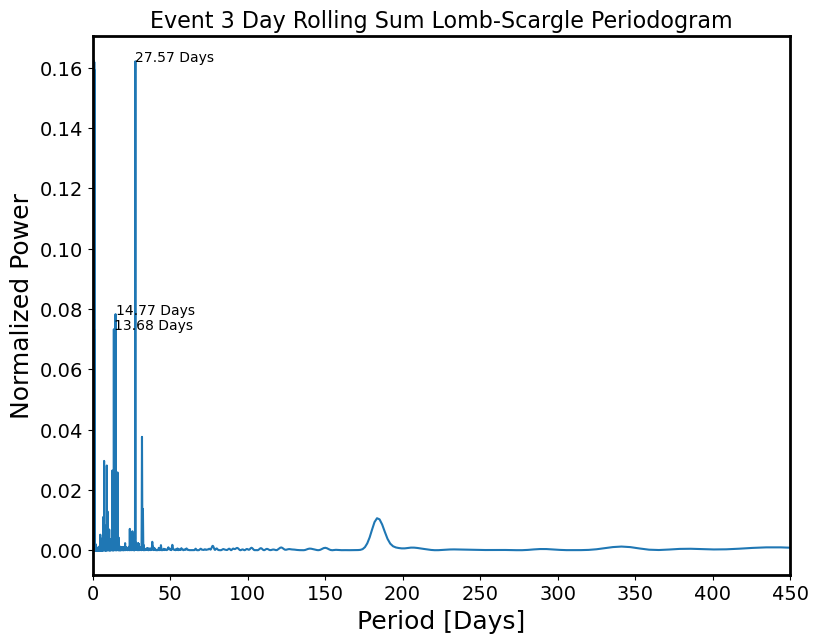

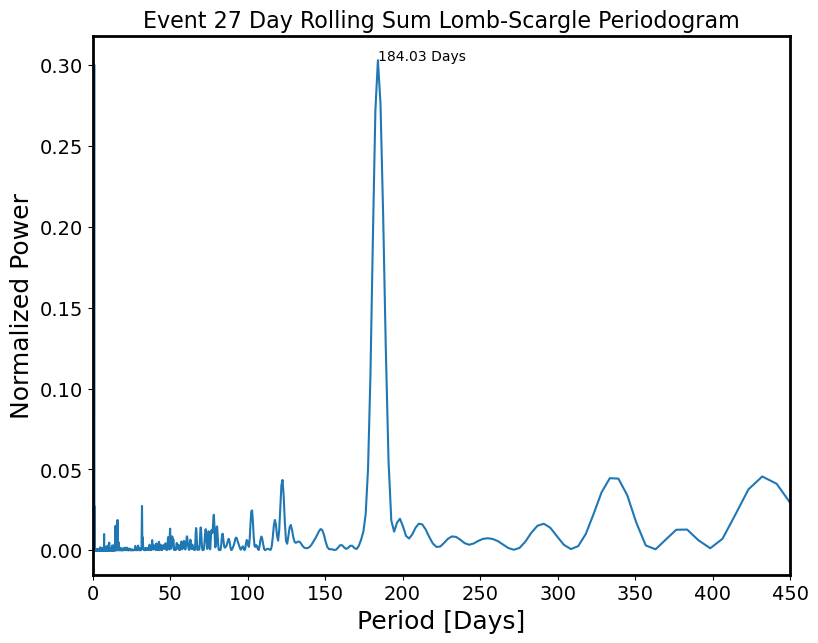

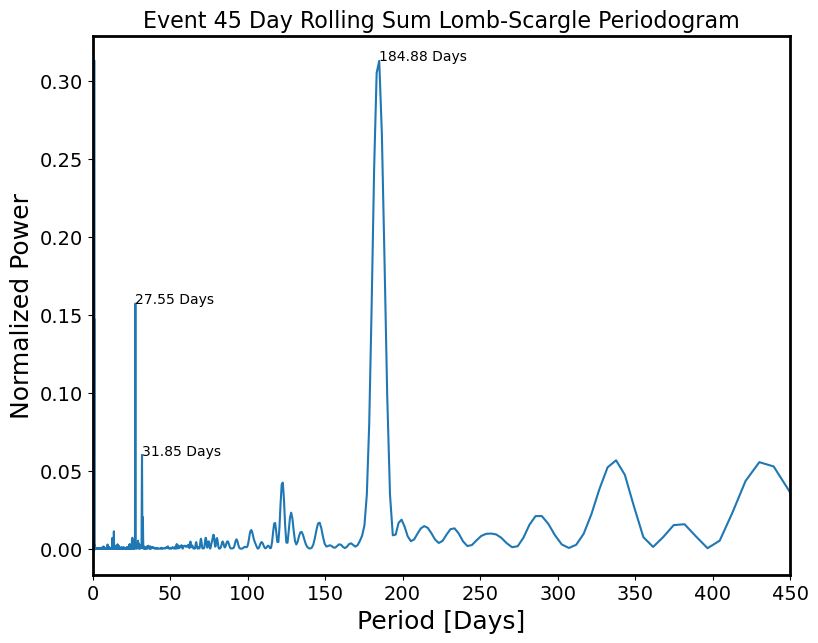

In [23]:
# Plot lomb scargles
SEC_TO_DAY = 3600 * 24
SEC_TO_HR = 3600
xlim = 450

slide = 1
for i, rolling_avg_dict in enumerate(rolling_avg_dicts):
    # Unpack dictionary
    skip_starts = rolling_avg_dict["skip_starts"]
    skip_ends = rolling_avg_dict["skip_ends"]
    skip_middles = rolling_avg_dict["skip_middles"]
    skips = rolling_avg_dict["skips"]
    tot_slips = rolling_avg_dict["tot_slips"]
    spacings = rolling_avg_dict["spacings"]
    window = rolling_avg_dict["window"]

    dates_as_sec = [a.timestamp() for a in skip_middles]
    tot_slips_masked = np.ma.masked_array(
        tot_slips, mask=np.invert(~np.isnan(tot_slips))
    )
    dates_as_sec_masked = np.ma.masked_array(
        dates_as_sec, mask=np.invert(~np.isnan(tot_slips))
    )
    tot_slips_masked = np.ma.compressed(tot_slips_masked)
    dates_as_sec_masked = np.ma.compressed(dates_as_sec_masked)
    tot_slips_detrended = scipy.signal.detrend(tot_slips_masked)

    # Spectrogram of rolling avg slips using lomb scargle
    frequency, power = LombScargle(dates_as_sec_masked, tot_slips_detrended).autopower()

    pks = scipy.signal.find_peaks(power[:10000], height=0.06)[0]
    fig, ax = plt.subplots(figsize=(9, 7))
    # ax.plot(frequency[pks], power[pks], 'ro')
    period = 1 / frequency / SEC_TO_DAY  # Days
    ax.plot(period, power)
    ax.set_title(
        f"Event {window} Day Rolling Sum Lomb-Scargle Periodogram", fontsize=16
    )
    ax.set_xlabel("Period [Days]", fontsize=18)
    ax.set_ylabel("Normalized Power", fontsize=18)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)
    ax.set_xlim(0, xlim)
    # ax.set_ylim(0,0.1)

    for pk, pwr in zip(period[pks], power[pks]):
        if pk < xlim:
            if pk > 0:
                print(f"{pk} Days, Power = {pwr}")
                ax.text(pk + 0.001e-5, pwr, f"{pk:.2f} Days")
            else:
                print(f"{pk} Hours, Power = {pwr}")
                ax.text(pk + 0.001e-5, pwr, f"{pk:.2f} Hours")

In [21]:
# Plotting function
def plot_rolling_avg_section(
    ax1,
    ax3,
    window,
    slide_len,
    skip_starts,
    skip_ends,
    skip_middles,
    skips,
    tot_slips,
    spacings,
):
    # Skipped slips by number of slips in xx period
    ax2 = ax1.twinx()
    (
        ax1.plot(
            dates_timeseries, ev_data["tidesgz05"], zorder=1, color="gray", alpha=0.4
        ),
    )
    for start, interval in zip(no_data["starts"][:], no_data["interval"][:]):
        start = datetime.datetime.strptime(start, "%Y-%m-%d %H:%M:%S")
        rect = plt.Rectangle(
            (start, -200), interval, 1000, facecolor="black", alpha=0.2, zorder=3
        )
        ax1.add_patch(rect)

    ax1.set_xlim(datetime.datetime(2008, 1, 1), datetime.datetime(2019, 6, 1))
    ax1.set_ylim(-120, 130)

    xerr = [(end - start) // 2 for start, end in zip(skip_starts, skip_ends)]
    norm_slips = [i / window for i in tot_slips]
    ax2.errorbar(skip_middles, norm_slips, xerr=xerr, fmt="o", color="black", zorder=2)
    # ax2.plot(skip_middles, tot_slips, color='blue')

    timestamps = [a.timestamp() for a in skip_middles]

    compressed_tot_slips = np.ma.masked_invalid(tot_slips)
    compressed_timestamps = np.ma.masked_where(
        np.ma.getmask(compressed_tot_slips), timestamps
    )
    compressed_tot_slips = np.ma.compressed(compressed_tot_slips)
    compressed_timestamps = np.ma.compressed(compressed_timestamps)

    coef = np.polyfit(compressed_timestamps, compressed_tot_slips, 1)
    print(coef)
    lst_sqrs_fit = np.poly1d(coef)
    print(lst_sqrs_fit[1])

    datetimes = [datetime.datetime.fromtimestamp(a) for a in compressed_timestamps]
    # ax2.plot(datetimes, lst_sqrs_fit(compressed_timestamps),color='blue',zorder=3)

    # Just a line so manually extract slope
    delta_y = (
        lst_sqrs_fit(compressed_timestamps)[-1] - lst_sqrs_fit(compressed_timestamps)[0]
    )
    delta_x = datetimes[-1] - datetimes[0]

    print(delta_y, delta_x)
    slope = delta_y / delta_x.total_seconds() * 3600 * 24 * 365
    print(slope)  # Slips / year
    ax1.yaxis.set_label_position("right")
    ax1.yaxis.tick_right()
    ax2.yaxis.set_label_position("left")
    ax2.yaxis.tick_left()
    ax1.set_xlabel("Date [yyyy]", size=22)
    ax1.set_ylabel("Tide Height [cm]", size=22)
    ax2.set_ylabel(f"Slips/Day [{window} Day Window]", size=22, color="black")
    ax1.xaxis.set_tick_params(labelsize=18)
    ax1.yaxis.set_tick_params(labelsize=18, color="gray")
    ax2.yaxis.set_tick_params(labelsize=18, colors="black")
    # ax2.spines['left'].set_color('red')

    ax4 = ax3.twinx()
    (
        ax3.plot(
            dates_timeseries, ev_data["tidesgz05"], zorder=1, color="gray", alpha=0.4
        ),
    )
    for start, interval in zip(no_data["starts"][:], no_data["interval"][:]):
        start = datetime.datetime.strptime(start, "%Y-%m-%d %H:%M:%S")
        rect = plt.Rectangle(
            (start, -200), interval, 1000, facecolor="black", alpha=0.2, zorder=3
        )
        ax3.add_patch(rect)

    st3 = datetime.datetime(2014, 1, 1)
    ed3 = datetime.datetime(2015, 6, 1)

    ax3.set_xlim(st3, ed3)
    # ax3.set_xlim(datetime.datetime(2008,12,8),datetime.datetime(2009,7,1))
    ax3.set_ylim(-155, 130)

    xerr = [(end - start) // 2 for start, end in zip(skip_starts, skip_ends)]
    # Segmet skipmiddles and norm_slips by date
    mask = [start > st3 and end < ed3 for start, end in zip(skip_middles, skip_ends)]
    skip_middles = np.array(skip_middles)[mask]
    norm_slips = np.array(norm_slips)[mask]
    xerr = np.array(xerr)[mask]

    ax4.errorbar(skip_middles, norm_slips, xerr=xerr, fmt="o", color="black", zorder=2)
    ax3.yaxis.set_label_position("right")
    ax3.yaxis.tick_right()
    ax4.yaxis.set_label_position("left")
    ax4.yaxis.tick_left()
    ax3.set_xlabel("Date [yyyy-mm]", size=22)
    ax3.set_ylabel("Tide Height [cm]", size=22)
    ax4.set_ylabel(f"Slips/Day [{window} Day Window]", size=22, color="black")
    ax3.xaxis.set_tick_params(labelsize=18)
    ax3.yaxis.set_tick_params(labelsize=18, color="gray")
    ax4.yaxis.set_tick_params(labelsize=18, colors="black")

    ssa_time = datetime.timedelta(days=182.63)
    ssa_start = datetime.datetime(2014, 3, 1)
    annotation(ax1, ssa_start, ssa_start + ssa_time, 92, 96, "$S_{sa}$")

    mm_time = datetime.timedelta(days=27.55)
    mm_start = datetime.datetime(2014, 6, 11)
    annotation(ax3, mm_start, mm_start + mm_time, 94, 98, "$M_{m}$")

    # ax1.set_title(f'{time_to_append} Day Rolling Average',size=22)

    ax1.set_title(f"{window} Day Window", size=22)
    # fig.tight_layout()

[-4.72210954e-09  1.09087618e+01]
-4.7221095431870305e-09
-1.684166812391097 4128 days, 0:00:00
-0.14891494344058875
27.574871966154536 Days, Power = 0.16214499626826087
14.769081693500299 Days, Power = 0.07828923321222668
13.682327919566902 Days, Power = 0.0732870284552016


/tmp/ipykernel_11509/3364273495.py:89: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


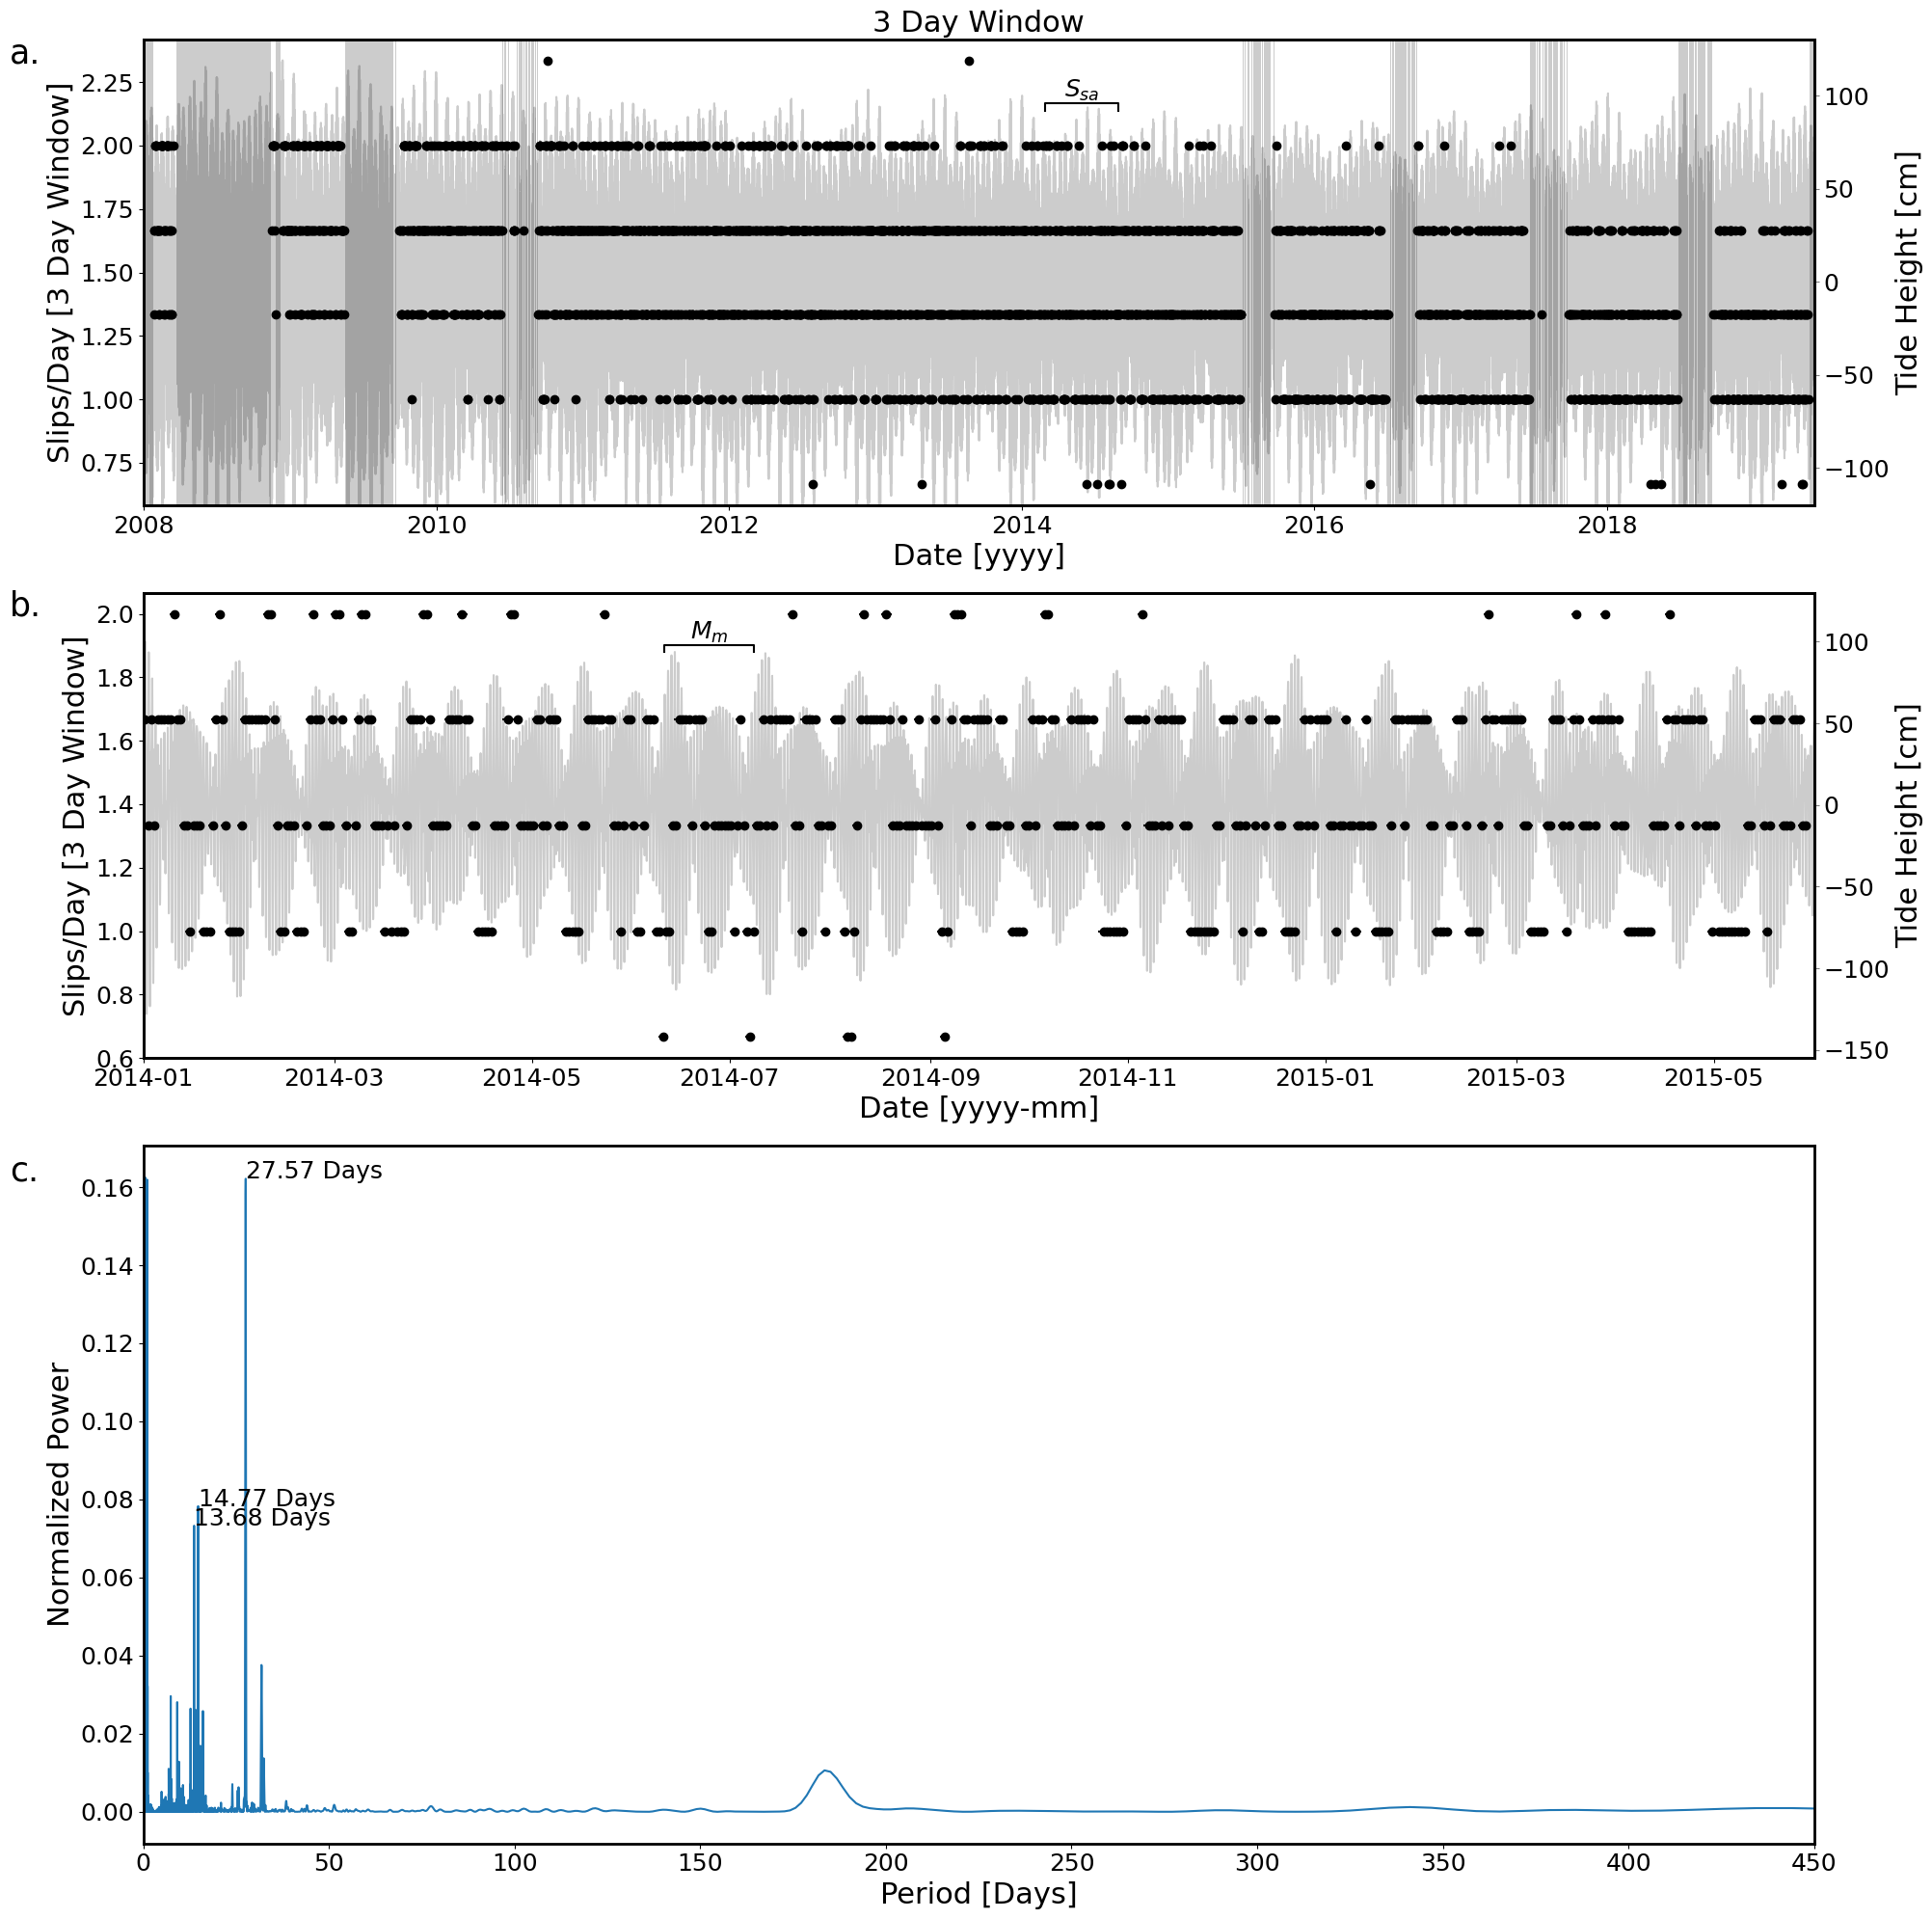

In [25]:
# Plot supplemental figures
# Plot for paper
# Plot for presentation
SEC_TO_DAY = 3600 * 24
SEC_TO_HR = 3600
xlim = 450

viridis = mpl.colormaps["viridis"].resampled(20)
# Add window to rolling avg dict
for i, window in enumerate([3, 27, 45]):
    rolling_avg_dicts[i]["window"] = window

fig, (ax1, ax2, ax3) = plt.subplots(
    3,
    1,
    figsize=[20, 20],
    gridspec_kw={"height_ratios": [1, 1, 1.5]},
    layout="constrained",
)

rolling_avg_dict = rolling_avg_dicts[0]

skip_starts = rolling_avg_dict["skip_starts"]
skip_ends = rolling_avg_dict["skip_ends"]
skip_middles = rolling_avg_dict["skip_middles"]
skips = rolling_avg_dict["skips"]
tot_slips = rolling_avg_dict["tot_slips"]
spacings = rolling_avg_dict["spacings"]
window = rolling_avg_dict["window"]
plot_rolling_avg_section(
    ax1,
    ax2,
    window,
    slide,
    skip_starts,
    skip_ends,
    skip_middles,
    skips,
    tot_slips,
    spacings,
)

# Lomb Scargle
dates_as_sec = [a.timestamp() for a in skip_middles]
tot_slips_masked = np.ma.masked_array(tot_slips, mask=np.invert(~np.isnan(tot_slips)))
dates_as_sec_masked = np.ma.masked_array(
    dates_as_sec, mask=np.invert(~np.isnan(tot_slips))
)
tot_slips_masked = np.ma.compressed(tot_slips_masked)
dates_as_sec_masked = np.ma.compressed(dates_as_sec_masked)
tot_slips_detrended = scipy.signal.detrend(tot_slips_masked)

# Spectrogram of rolling avg slips using lomb scargle
frequency, power = LombScargle(dates_as_sec_masked, tot_slips_detrended).autopower()

pks = scipy.signal.find_peaks(power[:10000], height=0.06)[0]
# ax.plot(frequency[pks], power[pks], 'ro')
period = 1 / frequency / SEC_TO_DAY  # Days
ax3.plot(period, power)
ax3.set_xlabel("Period [Days]", fontsize=22)
ax3.set_ylabel("Normalized Power", fontsize=22)
ax3.xaxis.set_tick_params(labelsize=18)
ax3.yaxis.set_tick_params(labelsize=18)
ax3.set_xlim(0, xlim)
# ax.set_ylim(0,0.1)

for pk, pwr in zip(period[pks], power[pks]):
    if pk < xlim:
        if pk > 0:
            print(f"{pk} Days, Power = {pwr}")
            ax3.text(pk + 0.001e-5, pwr, f"{pk:.2f} Days", fontsize=18)
        else:
            print(f"{pk} Hours, Power = {pwr}")
            ax3.text(pk + 0.001e-5, pwr, f"{pk:.2f} Hours", fontsize=18)


ax1.annotate("a.", (-0.08, 0.95), xycoords="axes fraction", fontsize=25)
ax2.annotate("b.", (-0.08, 0.95), xycoords="axes fraction", fontsize=25)
ax3.annotate("c.", (-0.08, 0.95), xycoords="axes fraction", fontsize=25)

st3 = datetime.datetime(2014, 1, 1)
ed3 = datetime.datetime(2015, 6, 1)

# Adds patch and zoom effect
# rect = plt.Rectangle(
#        (st3, -200), ed3-st3, 1000, facecolor="none", zorder=0,alpha=0.3, edgecolor="black", linewidth=2, linestyle="--")
# ax1.add_patch(rect)
# zoom_effect01(ax1, ax2, mdates.date2num(st3), mdates.date2num(ed3), ec="black", lw=2, alpha=0.3, ls="--")
fig.tight_layout()

In [76]:
slide = 1
for window in range(5, 20, 5):
    skip_starts, skip_ends, skip_middles, skips, tot_slips, spacings = rolling_average(
        window,
        slide,
        time_since_last_event_low_pk,
        time_to_next_event_low_pk,
        dist_gz05,
        ev_data,
        no_data,
    )
    plot_rolling_avg(
        window, slide, skip_starts, skip_ends, skip_middles, skips, tot_slips, spacings
    )

    # LOMB SCARGLE ->
    dates_as_sec = [a.timestamp() for a in skip_middles]
    tot_slips_masked = np.ma.masked_array(
        tot_slips, mask=np.invert(~np.isnan(tot_slips))
    )
    dates_as_sec_masked = np.ma.masked_array(
        dates_as_sec, mask=np.invert(~np.isnan(tot_slips))
    )
    tot_slips_masked = np.ma.compressed(tot_slips_masked)
    dates_as_sec_masked = np.ma.compressed(dates_as_sec_masked)
    tot_slips_detrended = scipy.signal.detrend(tot_slips_masked)

    # Spectrogram of rolling avg slips using lomb scargle
    frequency, power = LombScargle(dates_as_sec_masked, tot_slips_detrended).autopower()

    pks = scipy.signal.find_peaks(power[:10000], height=0.05)[0]
    fig, ax = plt.subplots(figsize=(9, 5))
    # ax.plot(frequency[pks], power[pks], 'ro')
    ax.plot(frequency, power)
    ax.set_title(
        f"Event {window} Day Rolling Average Lomb-Scargle Periodogram", fontsize=16
    )
    ax.set_xlabel("Frequency [Hz]", fontsize=18)
    ax.set_ylabel("Normalized Power", fontsize=18)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)
    ax.set_xlim(0, 0.05e-5)

    SEC_TO_DAY = 3600 * 24
    SEC_TO_HR = 3600
    for pk, pwr in zip(frequency[pks], power[pks]):
        if pk < 0.25e-5:
            print(f"{1/pk/SEC_TO_DAY} Days, Power = {pwr}")
            ax.text(pk + 0.001e-5, pwr, f"{1/pk/SEC_TO_DAY:.2f} Days")
        else:
            print(f"{1/pk/SEC_TO_HR} Hours, Power = {pwr}")
            ax.tect(0.01e-5, 0.1, f"{1/pk/SEC_TO_HR:.2f} Hours")

KeyboardInterrupt: 

In [27]:
dates_as_sec = [a.timestamp() for a in skip_middles]
tot_slips_masked = np.ma.masked_array(tot_slips, mask=np.invert(~np.isnan(tot_slips)))
dates_as_sec_masked = np.ma.masked_array(
    dates_as_sec, mask=np.invert(~np.isnan(tot_slips))
)
tot_slips_masked = np.ma.compressed(tot_slips_masked)
dates_as_sec_masked = np.ma.compressed(dates_as_sec_masked)
tot_slips_detrended = scipy.signal.detrend(tot_slips_masked)

In [5]:
# Spectrogram of rolling avg slips using lomb scargle
frequency, power = LombScargle(dates_as_sec_masked, tot_slips_detrended).autopower()

pks = scipy.signal.find_peaks(power[:10000], height=0.119)[0]
fig, ax = plt.subplots(figsize=(9, 5))
# ax.plot(frequency[pks], power[pks], 'ro')
ax.plot(frequency, power)
ax.set_title(
    f"Event {window} Day Rolling Average Lomb-Scargle Periodogram", fontsize=16
)
ax.set_xlabel("Frequency [Hz]", fontsize=18)
ax.set_ylabel("Normalized Power", fontsize=18)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_xlim(0, 0.05e-5)

# ax.set_ylim(0,2)

SEC_TO_DAY = 3600 * 24
SEC_TO_HR = 3600
for pk, pwr in zip(frequency[pks], power[pks]):
    if pk < 0.25e-5:
        print(f"{1/pk/SEC_TO_DAY} Days, Power = {pwr}")
        ax.text(pk + 0.001e-5, pwr, f"{1/pk/SEC_TO_DAY:.2f} Days")
    else:
        print(f"{1/pk/SEC_TO_HR} Hours, Power = {pwr}")
        ax.tect(0.01e-5, 0.1, f"{1/pk/SEC_TO_HR:.2f} Hours")

NameError: name 'LombScargle' is not defined

In [29]:
len(dates_as_sec_masked[:])

2817

In [6]:
# Spectrogram of rolling avg slips using lomb scargle
# Just the first or 2nd half of the overall timeseries
frequency, power = LombScargle(
    dates_as_sec_masked[: len(dates_as_sec_masked) // 2],
    tot_slips_detrended[: len(dates_as_sec_masked) // 2],
).autopower()
frequency, power = LombScargle(
    dates_as_sec_masked[len(dates_as_sec_masked) // 2 :],
    tot_slips_detrended[len(dates_as_sec_masked) // 2 :],
).autopower()
frequency, power = LombScargle(dates_as_sec_masked, tot_slips_detrended).autopower()
pks = scipy.signal.find_peaks(power, height=0.02)[0]
fig, ax = plt.subplots(figsize=(9, 5))
# ax.plot(frequency[pks], power[pks], 'ro')
ax.plot(frequency, power)
ax.set_title("Event  Day Rolling Average Lomb-Scargle Periodogram", fontsize=16)
ax.set_xlabel("Frequency [$s^{-1}$]")
ax.set_ylabel("Spectrum")
ax.set_xlim(0, 0.05e-5)
# ax.set_ylim(0,2)

SEC_TO_DAY = 3600 * 24
SEC_TO_HR = 3600
for pk, pwr in zip(frequency[pks], power[pks]):
    if pk < 0.25e-5:
        print(f"{1/pk/SEC_TO_DAY} Days, Power = {pwr}")
        if pwr > 0.03 and 1 / pk / SEC_TO_DAY < 200:
            ax.text(pk + 0.001e-5, pwr, f"{1/pk/SEC_TO_DAY:.2f} Days")
    else:
        print(f"{1/pk/SEC_TO_HR} Hours, Power = {pwr}")

NameError: name 'LombScargle' is not defined

In [7]:
# Plot tides to see trends with diurnal tides
def subplot(ax, place, dist, st, ed, triangles=False):
    """Subplot for Figure 3. Plots tides and events colored by time since last event

    Parameters
    ----------
    ax : matplotlib.pyplot.axis
        Axis to plot on
    place : str
        Place tides are modeled at
    dist : dict
        Dict of high and low tides
    st : datetime.datetime
        Start time of panel
    ed : datetime.datetime
        End time of panel;
    triangles : bool, optional
        Flag to plot low and high tide triangles. Default is False.
    """
    ax.plot(dates_timeseries, ev_data[f"tides{place}"], zorder=0, color="gainsboro")
    if triangles:
        ax.scatter(dist["pk_date"], dist["pk_tide"], zorder=0, color="gray", marker="v")
        ax.scatter(
            dist["vly_date"], dist["vly_tide"], zorder=0, color="gray", marker="^"
        )
    hr_since_last_ev = [
        (a.days * 24 * 3600 + a.seconds) / 3600 for a in ev_data["time_since_last_ev"]
    ]
    masked_hr = np.ma.masked_where(np.array(hr_since_last_ev) > 32, ev_data["ev_time"])
    cax = ax.scatter(
        masked_hr,
        ev_data[f"tide_event_time_{place}"],
        c=hr_since_last_ev,
        zorder=2,
        cmap="viridis",
        vmin=0,
        vmax=32,
    )
    cbar = plt.colorbar(cax)
    cbar.set_label("Time Since Last Event [hr]", size=22)
    cbar.ax.tick_params(labelsize=18)
    ax.set_xlim(st, ed)
    # ax.set_xlim(datetime.datetime(2012,12,8),datetime.datetime(2013,5,20))
    ax.set_xlabel("Date [yyyy]", size=22)
    if triangles:
        ax.set_xlabel("Date [yyyy-mm]", size=22)
    ax.set_ylabel("Tide Height [cm]", size=22)
    ax.xaxis.set_tick_params(labelsize=18)
    ax.yaxis.set_tick_params(labelsize=18)

    for start, interval in zip(no_data["starts"][:], no_data["interval"][:]):
        start = datetime.datetime.strptime(start, "%Y-%m-%d %H:%M:%S")
        rect = plt.Rectangle(
            (start, -200), interval, 1000, facecolor="black", alpha=0.1, zorder=3
        )
        ax1.add_patch(rect)

    # ax.set_title(f'{place} Tide Reference',size=20)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=[20, 10])
st = datetime.datetime(2012, 10, 1)
ed = datetime.datetime(2013, 3, 1)
subplot(ax1, "gz05", dist_gz05, st, ed, triangles=True)

st = datetime.datetime(2013, 3, 1)
ed = datetime.datetime(2013, 7, 1)

subplot(ax2, "gz05", dist_gz05, st, ed, triangles=True)
fig.tight_layout()

NameError: name 'plt' is not defined